In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
 !pip install -q wordcloud
import wordcloud
 
import nltk
nltk.download('stopwords')
 
!pip install FastText
 
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 68 kB 3.0 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for FastText: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3127233 sha256=c3ccd31dc4619c4a8fe5aa1a35c416efc483cf62611c294791f97ba1c2de73c8
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built FastText
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
 from __future__ import absolute_import, division, print_function
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from numpy import mean
 
 
 
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import time
import pickle
 
 
# Normalization
def textNormalization(text):
    text=text.replace('ሃ','ሀ')
    text=text.replace('ሐ','ሀ')
    text=text.replace('ሓ','ሀ')
    text=text.replace('ሑ','ሁ')
    text=text.replace('ሒ','ሂ')
    text=text.replace('ሔ','ሄ')
    text=text.replace('ሕ','ህ')
    text=text.replace('ሖ','ሆ')
 
    text=text.replace('ኀ','ሀ')
    text=text.replace('ኁ','ሁ')
    text=text.replace('ኂ','ሂ')
    text=text.replace('ኃ','ሀ')
    text=text.replace('ኄ','ሄ')
    text=text.replace('ኅ','ህ')
    text=text.replace('ኆ','ሆ')
            
    text=text.replace('ዐ','አ')
    text=text.replace('ዑ','ኡ')
    text=text.replace('ዒ','ኢ')
    text=text.replace('ዓ','ኣ')
    text=text.replace('ዔ','ኤ')
    text=text.replace('ዕ','እ')
    text=text.replace('ዖ','ኦ')
 
    text=text.replace('ሠ','ሰ')
    text=text.replace('ሡ','ሱ')
    text=text.replace('ሢ','ሲ')
    text=text.replace('ሣ','ሳ')
    text=text.replace('ሤ','ሴ')
    text=text.replace('ሥ','ስ')
    text=text.replace('ሦ','ሶ')
 
    text=text.replace('ጸ','ፀ')
    text=text.replace('ጹ','ፁ')
    text=text.replace('ጺ','ፂ')
    text=text.replace('ጻ','ፃ')
    text=text.replace('ጼ','ፄ')
    text=text.replace('ጽ','ፅ')
    text=text.replace('ጾ','ፆ')
    text=text.replace('ዉ','ው')
    
    return text
# sentence_to_wordlist Remove any non amharic alphabet characters from the sentence
def sentence_to_wordlist(raw):
     clean = re.sub("[^ሀ-ፖ]"," ", raw)
     words = clean.split()
     words=stopWordsRemove(words)
     return words
 
def sentence_Amh(raw):
     AmhSen = re.sub("[^ሀ-ፖ]"," ", raw)
     #words = clean.split()
     #words=stopWordsRemove(words)
     return str(AmhSen)
# Remove Stop words
def stopWordsRemove(word_tokens):
    con_word=[]
    fn = glob.glob("drive/MyDrive/FinalCode/amhStopwordslist.txt")
    #stop_words=nltk.corpus.stopwords.words("amStopwordslist.txt")
    #stop_words=stopwords.words('amStopwordslist.txt')
    stop=u''
    for f in fn:
        with codecs.open(f,'r','utf-8') as stp:
            stop+=stp.read()
    
    stop_words=stop.split()
    stop_words=get_stop_words()#[textNormalization(sw) for sw in stop_words]
    for a_words in word_tokens:
        a_words=trim_elongated(str(a_words))
            ## for cword in a_words:
        if textNormalization(str(a_words)) not in stop_words:
            con_word.append(a_words)
 
    return con_word
 
def get_stop_words():
    with codecs.open('drive/MyDrive/FinalCode/amhStopwordslist.txt','r', 'utf-8') as f:
        stopwords=f.readlines()
        stop_set=set(textNormalization(m.strip()) for m in stopwords)
        return frozenset(stop_set)
    
def trim_elongated(s):
    wrds=[]
    for word in s.split():
        word=re.sub(r'(?i)(.)\1+', r'\1\1', word)
        #re.sub(r'(?i)(.)\1+$', r'\1\1', word)
        wrds.append(word)
    s=' '.join(w for (w) in wrds)
    return s   #re.sub(r'(?i)(.)\1+', r'\1\1', s)
 
#Read Compound and Abreviation words and write them on file to manually observe their nature
def readCmpAbbrtest(text):
    
    exp= r"(\w+[-'./]\w+)*"
    #abbr=re.findall(exp,text)
        
    abbr=re.sub(exp,'',str(text))
    return str(abbr)
def Load_Data():
    ssn=sentTokeniz4OrtStrAmh() # list of Tokenized sentences from Amharic files with orthography 
    uns=readUnstrAmhTexts() # list of tokenized sentences from Unstructured Amharic Files
    fnl=uns+ssn
    clnAmh=[]
    
    for sen in fnl:
        temp=sentence_Amh(str(sen)) 
        temp=readCmpAbbrWord(str(sen)) 
        temp.strip()
        if (len(temp)>0):
            clnAmh.append(temp)
           
    print("The unstructured data corpus contains a total of {0:,} sentences".format(len(uns)))
    print("The Amharic litratures used for this study contains {0:,} sentences".format(len(ssn)))
        
    print("The whole corpus to train Amharic embedding contains a total of {0:,} sentences before any preprocessing".format(len(fnl)))
    print("The whole corpus to train Amharic embedding contains a total of {0:,} Amharic sentences ".format(len(clnAmh)))
    
    print()
    return clnAmh
 
    
def cleanSent(senList):
    
    allsen=[]
    unique=[]
    for senPost in senList:
        if(len(senPost))>0:
            allsen.append(sentence_to_wordlist(str(senPost)))
        """for word in sentence_to_wordlist(str(senPost)):
            
            if word not in unique:
                
                unique.append(word)"""
    
    
    sent_count1=len(allsen)
    token_count1 = sum([len(sentence) for sentence in allsen])
    print("The corpus contains {0:,} sentences".format(sent_count1))
    print("The corpus contains a total of {0:,} tokens".format(token_count1))
    """print("The corpus contains Unique {0:,} tokens".format(len(unique)))"""
    print()
    
    return allsen
 
def sentTokeniz4OrtStrAmh():
    corpus=u''
    file_names = sorted(glob.glob("drive/MyDrive/FinalCode/AmharicTrainEmbedding/*.txt"))
    
    #sent=[]
    # to read each corpus files' each line and the total number of characters with in the files which helps to compare it with an output after the necessary cleaning
    
    for file_name in file_names:
        
        with codecs.open(file_name,"r","UTF-8") as corpus_file:
            corpus += corpus_file.read()
    
    corpus=corpus.replace('::','። ')
    corpus=corpus.replace('።','። ')
    
    
    sent=re.split(r"[።?!]",corpus)
    sent=[readCmpAbbrWord(str(sen)) for sen in sent]
    sent=[trim_elongated(str(sen)) for sen in sent]
    return sent
 
def readUnstrAmhTexts():
    data=pd.read_csv('drive/MyDrive/FinalCode/AmharicTrainEmbedding/OrginalrawPosts.tsv',header=None,delimiter='\t')
    data.columns=['Posts','Label']
    sentences=[readCmpAbbrWord(str(sen)) for sen in data.Posts]
    sentences=[str(sen).replace('::','፡፡ ') for sen in sentences]
    
    sentences=[str(sen).replace('፡፡','. ') for sen in sentences]
    sentences=[trim_elongated(str(sen)) for sen in sentences]
    
    sent=[]
    for sen in sentences:
        for line in sent_tokenize(str(sen)):
            sent.append(line)
    
    return sent
def ReadCleanSentc2v():
    
    allsen=[]
 
    fn=codecs.open('CleanAmhSent1.txt','r','utf-8')
    sents=fn.readlines()
    for line in sents:
        if(len(line))>0:
            allsen.append(sentence_to_wordlist(str(line).strip()))
            
    return allsen
        
def NormalizedTokens(senTokens):
    sent=[]
    for sen in senTokens:
        
        word=[textNormalization(str(token)) for token in sen]
        sent.append(word)
    
    return sent
            
def readCmpAbbrWord(txt):
    
    exp= "(^[ሀ-ፖ]+['./][ሀ-ፖ]+)$"
    
    lst=[str(abr) for abr in txt.split() if re.search(exp,abr) ]
    lstm=[tm for tm in lst if(tm!='')]
    temp=','.join (w for w in lstm if(w!=''))
    crc=[]
    ea=str(temp).split(',')
    """ the searched and Matched expression found punctuation mark will be removed and 
        the remaining character or unigrams will be joind"""
    for ab in str(temp).split(','):
        tp=''.join (w for w in re.split(r"[-'./]",str(ab)))
        crc.append(tp)
    # the original abrrevaition or compound word will be replaced by the word without the punctuation mark
    
    for r,rp in zip(ea,crc):
        txt=txt.replace(r,rp)
    
    return (txt)

In [ ]:
 def amhEmbeddingTrain(allsen,d):
 
    # dimensionality of the resulting word vector
    
    min_word_count = 2
 
# Number of thread to run in parallel
    num_workers = multiprocessing.cpu_count()
    
    # Number of left and right words to take for context window 
    context_size = 5
    downsampling = 1e-3
    seed = 1
    #for x in dim:
    
    tic=time.perf_counter()  
    g2v = w2v.Word2Vec(
        sg=1,
        seed=seed,
        workers=num_workers,
        size=d,
        min_count=min_word_count,
        window=context_size,
        sample=downsampling
        )
    g2v.build_vocab(allsen, progress_per=100, keep_raw_vocab=False, trim_rule=None)
    g2v.train(
            allsen, 
            total_examples=g2v.corpus_count, 
            total_words=None, epochs=g2v.epochs, 
            start_alpha=None, end_alpha=None, 
            word_count=0, 
            queue_factor=2, 
            report_delay=1.0, 
            compute_loss=False)
    md="sg"
    dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/sg/AmW2vecSG50.pkl"
 
    embeddings_index = {}    
    for i in range(len(g2v.wv.vocab)):
        word = list(g2v.wv.vocab)[i]
        coefs = g2v[word]
        embeddings_index[word] = coefs   
  # Save model and embeddings index    
    pickle.dump(embeddings_index, open(dr, 'wb'))
    #g2v.save('drive/MyDrive/Amhword2vec-300d')
 
    g2v.wv.save('drive/MyDrive/FinalCode/Finaltrained/AmhW2V/sg/AmW2vecSG50', ignore=[])
    all_word_vectors_matrix = g2v.wv.syn0
    print("AW2V Skip-Gram Dimension{0:,}".format(d))
    print(all_word_vectors_matrix)
    print(g2v.wv.most_similar("ጋላ"))
    print(g2v.wv.most_similar("ወያኔ"))
    print(g2v.wv.most_similar("ነፍጠኛ"))
    print(g2v.wv.most_similar("አሮሞ"))
    print(g2v.wv.most_similar("አማራ"))
    print(g2v.wv.most_similar("ትግራዋይ"))
           
    print() 
    toc=time.perf_counter()
    print(f"The time it takes is {toc-tic:0.4f} seconds")
    #got2vec = w2v.Word2VecKeyedVectors.load(os.path.join("trained", "Amw2vec50.w2v"))
 
def W2VamhEmbedding(allsen,d,sg):
    # dimentionality of the resulting word vector
 
    min_word_count = 1
 
# Number of thread to run in parallel
    num_workers = multiprocessing.cpu_count()
    
    # Number of left and right words to take for context window 
    context_size = 5
    downsampling = 1e-2
    seed = 1
    
    
    tic=time.perf_counter()  
    g2v = w2v.Word2Vec(
        sg=sg,
        seed=seed,
        workers=num_workers,
        size=d,
        min_count=min_word_count,
        window=context_size,
        sample=downsampling,
        iter=10
        )
    g2v.build_vocab(allsen)
    g2v.train(
            allsen, 
            total_examples=g2v.corpus_count, 
            total_words=g2v.corpus_total_words, epochs=g2v.epochs, 
            start_alpha=None, end_alpha=None, 
            word_count=0, 
            queue_factor=2, 
            report_delay=1.0, 
            compute_loss=False)
    if(sg==1):
       md="sg"
    else:
       md="cbw"
    dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/"+md
    """embeddings_index = {}        
    for i in range(len(g2v.wv.vocab)):
        word = list(g2v.wv.vocab)[i]
        coefs = g2v[word]
        embeddings_index[word] = coefs   
  # Save model and embeddings index    
    pickle.dump(embeddings_index, open(os.path.join((str(dr),'AmW2vecCBOW{0:,}.pkl'.format(d))), 'wb'))
    #g2v.save('drive/MyDrive/Amhword2vec-300d')    
"""
    g2v.wv.save(os.path.join(str(dr), "AmW2vec{0:,}.bin".format(d)), ignore=[])
    all_word_vectors_matrix = g2v.wv.syn0
    print("AW2V CBOW Dimension{0:,}".format(d))
    print(all_word_vectors_matrix)
    print(g2v.wv.most_similar("ጋላ"))
    print(g2v.wv.most_similar("ወያኔ"))
    print(g2v.wv.most_similar("ነፍጠኛ"))
    print(g2v.wv.most_similar("ቆምጬ"))
    print(g2v.wv.most_similar("ኦሮሞ"))
    print(g2v.wv.most_similar("አማራ"))
    print(g2v.wv.most_similar("ትግሬ"))
    
    print()       
    
    toc=time.perf_counter()
    
    print(f"it takes {toc-tic:0.4f} seconds to train Amw2vec Embedding dimension{0:,}".format(d))
 
def fastTextAmhEmbedding(word_tokens,sgm,d):
    
    
  
# Number of thread to run in parallel
    num_workers = multiprocessing.cpu_count()
    min_word_count = 1
    # Number of left and right words to take for context window 
    context_size = 5
    downsampling = 1e-2
    seed = 1
      
    tic=time.perf_counter() 
    fast_Text_model = FastText(
                          sg=sgm,
                          min_n=2,
                          seed=seed,
                          size=d,
                          window=context_size,
                          min_count=min_word_count,
                          sample=downsampling,
                          workers = num_workers,
                          iter=10)
    fast_Text_model.build_vocab(word_tokens)
 
# Update gensim fastText model using new data
    fast_Text_model.train(word_tokens, total_examples=fast_Text_model.corpus_count, epochs=fast_Text_model.epochs, total_words=fast_Text_model.corpus_total_words)
    if(sgm==1):
        md="sg"
    else:
        md="cbw"
    dr="drive/MyDrive/FinalCode/FinalTrained/Amfstext/"+md
            
    fast_Text_model.save(os.path.join(str(dr), "Amfstext{0:,}.bin".format(d)), ignore=[])
    
# Load saved gensim fastText model
    #fast_Text_model = w2v.Word2Vec.load("trained1/fastTextAmh")
    print(md+"AmhfastText{0:,}Dimension".format(d))
    print(fast_Text_model.wv.similarity('ትግራዋይ', 'ትግራዋይ'))
    print(fast_Text_model.wv.similarity('ጥንባታም', 'ጢንባታም'))
    print(fast_Text_model.wv.similarity('አንቴ', 'አንተ'))
    print(fast_Text_model.wv.similarity('ኦሮሞ', 'ዖሮሞ'))
    print(fast_Text_model.wv.similarity('ሀላፊነት', 'ሓላፊነት'))
    print(fast_Text_model.wv.similarity('ጸሀይ', 'ፀሀይ'))
    print(fast_Text_model.wv.similarity('ጸኀይ', 'ፀሀይ'))
    print(fast_Text_model.wv.similarity('ሰይጣን', 'ሠይጣን'))
    print(fast_Text_model.wv.similarity('አለቀ', 'ደለቀ'))
    
 
    print() 
    print("Top 10 Similar Words for ጋላ:") 
    print(fast_Text_model.wv.most_similar(positive=["ጋላ"], topn=10))
    
    print() 
    print("Top 10 Similar Words for ወያኔ:") 
    print(fast_Text_model.wv.most_similar(positive=["ወያኔ"], topn=10))
    
    print() 
    print("Top 10 Similar Words for ነፍጠኛ:") 
    print(fast_Text_model.wv.most_similar(positive=["ነፍጠኛ"], topn=10))
    
    print() 
    print("Top 10 Similar Words for ቆምጬ:") 
    print(fast_Text_model.wv.most_similar(positive=["ቆምጬ"], topn=10))
    
    print() 
    print("Top 10 Similar Words for ኦሮሞ:") 
    print(fast_Text_model.wv.most_similar(positive=["ኦሮሞ"], topn=10))
    
    print() 
    print("Top 10 Similar Words for አማራ:") 
    print(fast_Text_model.wv.most_similar(positive=["አማራ"], topn=10))
    
    print() 
    print("Top 10 Similar Words for ትግሬ:") 
    print(fast_Text_model.wv.most_similar(positive=["ትግሬ"], topn=10))
  
    
    toc=time.perf_counter()
    
    print(f"it takes {toc-tic:0.4f} seconds to train Amfstext Embedding dimension{0:,}".format(d))
def prepareEmbMatrixFinal(embeddings_index,word_index, emb_dim):
  # Load pre-trained embedding index
    #embeddings_index = pickle.load(open('drive/MyDrive/AmhPrembeddings_300d.pkl', 'rb'))
 
    # Prepare embedding matrix from pre-trained model
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
 
    return embedding_matrix
 
def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer
 
def AmEmbeddingIndexMain(dr,fn):
 
    #dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/sg"
    model=w2v.Word2VecKeyedVectors.load(os.path.join(dr,fn)) #"AmW2vecSG50.bin"))
 
    embeddings_index = {}
    for i in range(len(model.wv.vocab)):
        
        word = list(model.wv.vocab)[i]
        coefs = model[word]
        embeddings_index[word] = coefs
    return embeddings_index
def AmEmbeddingIndex():#(dr,fn):
 
    dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/sg"
    model=w2v.Word2VecKeyedVectors.load(os.path.join(dr,"AmW2vecSG50.bin"))
 
    embeddings_index = {}
    for i in range(len(model.wv.vocab)):
        
        word = list(model.wv.vocab)[i]
        coefs = model[word]
        embeddings_index[word] = coefs
    return embeddings_index
 
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
 
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
 import pandas
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils.np_utils import to_categorical
from keras.layers import LSTM,Embedding,GlobalMaxPooling1D, Dropout,Flatten, Bidirectional,TimeDistributed,Input,merge,Conv1D,MaxPooling1D,concatenate,Conv2D
from keras.preprocessing import sequence
from keras.models import Model
from keras import backend as K
from sklearn import model_selection
from sklearn.metrics import classification_report
from keras import optimizers
from keras import regularizers 
from keras.utils.vis_utils import plot_model
from keras import backend as K
 
from keras.layers.convolutional import Conv1D
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score 
from sklearn import metrics as ms
from sklearn.metrics import classification_report
from tensorflow import keras
 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives+K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives+K.epsilon())
    return precision
 
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def create_model(vocab_size, maxlen,embed_dim,mpng):
 
    opt=keras.optimizers.RMSprop(learning_rate=0.001)
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, 
                           
                           input_length=maxlen, 
                           trainable=True))
    model.add(Conv1D(filters=64, kernel_size=5, padding='same',activation='relu'))    
    model.add(GlobalMaxPooling1D()) #model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(1, activation='sigmoid'))
# compile network
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1_m,precision_m,recall_m])
# summarize defined model
    model.summary()
    plot_model(model, to_file=mpng, show_shapes=True)
    return model
 
def create_model1(vocab_size, maxlen,embed_dim,embed_mtrx,mpng):
    opt=keras.optimizers.RMSprop(learning_rate=0.001)
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, 
                           weights=[embed_mtrx], 
                           input_length=maxlen, 
                           trainable=True))
    model.add(Conv1D(filters=64, kernel_size=5, 
                     padding='same',
                     activation='relu'))    
    model.add(GlobalMaxPooling1D()) 
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(1, activation='sigmoid'))
# compile network
    model.compile(loss='binary_crossentropy', 
                  optimizer=opt, 
                  metrics=['accuracy',f1_m,precision_m,recall_m])
# summarize defined model
    model.summary()
    plot_model(model, to_file=mpng, show_shapes=True)
    return model
 
def create_model_param(vocab_size, maxlen,embed_dim,embed_mtrx,do,opt,mpng):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, 
                           weights=[embed_mtrx], 
                           input_length=maxlen, 
                           trainable=True))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(do))
    model.add(Dense(1, activation='sigmoid'))
# compile network
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1_m,precision_m,recall_m])
# summarize defined model
    model.summary()
    plot_model(model, to_file=mpng, show_shapes=True)
    return model

In [ ]:
from sklearn.metrics import confusion_matrix# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay
def final_train_test(model,x,y,svmd,epochs,batch_size):
 
    tic=time.perf_counter()   
    kf = KFold(n_splits=5,shuffle=True) # defining fold parameter
# created empty list to append score and error
    training_error = []
    training_accuracy = []
    testing_error = []
    testing_accuracy = []
    training_recall = []
    training_precision = []
    training_f1score = []
    testing_recall = []
    testing_precision = []
    testing_f1score = [] 
    scores=numpy.zeros(0,dtype=float) 
    i=0
#for train_index,test_index in kf.split(x):
    for train_index,test_index in kf.split(x):
    #model=define_model(vocab_size, maxlen,embedding_dim)
     # divide the data into train and test
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y[train_index],y[test_index]
         
     
        history=model.fit(x_train, y_train, verbose=True, validation_data=(x_test, y_test),epochs=epochs, batch_size=batch_size)     #get the prediction for train and test data 
        train_data_pred = model.predict(x_train)
        test_data_pred = model.predict(x_test)
     #appending the errors to the list
        training_error.append(mean_absolute_error(y_train,train_data_pred))
        testing_error.append(mean_absolute_error(y_test,test_data_pred))
     #appending the accuracy to the list
    
    
        loss,accuracy,f1_score,precision,recall = model.evaluate(x_train, y_train, verbose=True)
        print("Training Accuracy: {:.4f}".format(accuracy))
        print("Training Precision: {:.4f}".format(precision))
        print("Training Recall: {:.4f}".format(recall))    
        print("Training F1_Score: {:.4f}".format(f1_score)) 
        training_accuracy.append(accuracy) 
        training_recall.append(recall)        
        training_precision.append(precision)
        training_f1score.append(f1_score)   
        loss,accuracy,f1_score,precision,recall  = model.evaluate(x_test, y_test, verbose=True)
        print("Testing Accuracy:  {:.4f}".format(accuracy))
        print("Testing Precision: {:.4f}".format(precision))
        print("Testing Recall: {:.4f}".format(recall))    
        print("Testing F1_Score: {:.4f}".format(f1_score))   
        testing_accuracy.append(accuracy) 
        testing_recall.append(recall)            
        testing_precision.append(precision)
        testing_f1score.append(f1_score)  
        
        ypred=test_data_pred #  model .predict(x_test)        
        ypred[ypred>0.5]=1
        ypred[ypred<=0.5]=0
        conf_matrix  =confusion_matrix(y_test,ypred)
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(conf_matrix.shape[1]):
            for j in range(conf_matrix.shape[0]):
                ax.text(x=i, y=j,s=conf_matrix[j, i], va='center', ha='center', size='xx-large')

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()        
        plot_history(history)
 
     
    print("Average training accuracy is:",mean(training_accuracy))
    print("Average training precision is:",mean(training_precision))
    print("Average training recall is:",mean(training_recall))
    print("Average training f1score is:",mean(training_f1score))

    print("Average testing accuracy is:",mean(testing_accuracy))
    print("Average testing precision is:",mean(testing_precision))
    print("Average testing recall is:",mean(testing_recall))
    print("Average testing f1score is:",mean(testing_f1score))   
    model.save(svmd)
    toc=time.perf_counter()
    
    print(f"it takes {toc-tic:0.4f} seconds")

In [ ]:
def preprocess_data(data):
    
    data.columns=['Posts','Label']
    data.dropna()
    sentences=[readCmpAbbrWord(str(sen)) for sen in data.Posts]
    sentences=[str(sen).replace('::','፡፡ ') for sen in sentences]
    
    sentences=[str(sen).replace('፡፡','. ') for sen in sentences]
    sentences=[trim_elongated(str(sen)) for sen in sentences]
    sentences=[sentence_Amh(str(sen)) for sen in sentences]
    sentences=[sentence_to_wordlist(str(sen)) for sen in sentences]
    sentences1=sentences

#sentences1=NormalizedTokens(sentences1)
    data['Text_Final']=[' '.join(sen) for sen in sentences]
#embedding_index=AmEmbeddingIndex() 
    nv=float("NaN")
    data.replace("",nv,inplace=True)
    data1=data.dropna()
    return data1

In [ ]:
sent=Load_Data()
allSen=cleanSent(sent)
sentNor=NormalizedTokens(allSen)

The unstructured data corpus contains a total of 52,299 sentences
The Amharic litratures used for this study contains 17,743 sentences
The whole corpus to train Amharic embedding contains a total of 70,042 sentences before any preprocessing
The whole corpus to train Amharic embedding contains a total of 69,925 Amharic sentences 

The corpus contains 69,925 sentences
The corpus contains a total of 921,247 tokens



In [ ]:
 fastTextAmhEmbedding(allSen,0,300)

cbwAmhfastText300Dimension
1.0
0.9127725
0.9480373
0.98455405
0.9889271
0.982393
0.9650338
0.95989263
0.4912926

Top 10 Similar Words for ጋላ:
[('ናላ', 0.9908062815666199), ('ጋቤላ', 0.9897198677062988), ('ጋዱላ', 0.9891694784164429), ('ታፔላ', 0.9889384508132935), ('ሻላ', 0.9851619601249695), ('ቹኡላ', 0.9837507009506226), ('ሸለላ', 0.9836069345474243), ('ቲኪላ', 0.9835989475250244), ('ሾላ', 0.9827528595924377), ('ሸላ', 0.9825865030288696)]

Top 10 Similar Words for ወያኔ:
[('ወያኔነ', 0.9349029660224915), ('ደምድሞ', 0.9318791627883911), ('ወሀቢይእኔ', 0.9312913417816162), ('ወያላ', 0.9308668375015259), ('ወየኔ', 0.9291768074035645), ('ቄጣላ', 0.9289337396621704), ('ኦላ', 0.9236739873886108), ('ኦፒላ', 0.9227077960968018), ('ወያቴ', 0.9221973419189453), ('ደጠሞ', 0.9219750761985779)]

Top 10 Similar Words for ነፍጠኛ:
[('ነፍጣኛ', 0.9913812875747681), ('ነፊጠኛ', 0.9883975982666016), ('ነፋጠኛ', 0.9880380630493164), ('ነዉረኛ', 0.9848028421401978), ('ነጌቲቭ', 0.9784406423568726), ('ነጩ', 0.9782189130783081), ('ነዚ', 0.9780911803245544), ('ነችኮ'

In [ ]:
 
fastTextAmhEmbedding(allSen,1,300)

sgAmhfastText300Dimension
1.0
0.9572129
0.899847
0.92118466
0.96084964
0.9472898
0.8651222
0.8359145
0.4955012

Top 10 Similar Words for ጋላ:
[('ጋቤላ', 0.9457021951675415), ('ጋላምጋላ', 0.9412878751754761), ('ጎሬላ', 0.9405623078346252), ('ጋዱላ', 0.9339214563369751), ('ሸቃላ', 0.9257928133010864), ('ናላ', 0.9200365543365479), ('ቱላ', 0.9180481433868408), ('ሱላ', 0.9168415665626526), ('ጋላለጋላ', 0.9167962670326233), ('ሾላ', 0.9154922962188721)]

Top 10 Similar Words for ወያኔ:
[('ወያኔነ', 0.9349595904350281), ('ወያኔማ', 0.9161624908447266), ('ፀረወያኔ', 0.8659809827804565), ('ወያቴ', 0.8558867573738098), ('ወያነ', 0.8497372269630432), ('ህወሀትወያኔ', 0.8479183912277222), ('ወያኔንሻቢያ', 0.8444050550460815), ('ወያላ', 0.84404057264328), ('ትህነግወያኔ', 0.8406664133071899), ('ወኔ', 0.8302063941955566)]

Top 10 Similar Words for ነፍጠኛ:
[('ጅግናነፍጠኛ', 0.9436091184616089), ('ነውነፍጠኛ', 0.9376168251037598), ('ነፍጣኛ', 0.9286400079727173), ('ነፋጠኛ', 0.8943289518356323), ('ሰለነፍጠኛ', 0.8932777047157288), ('ነፊጠኛ', 0.8928457498550415), ('ናፍጠኛ', 0.89

In [ ]:
W2VamhEmbedding(allSen,300,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


AW2V CBOW Dimension300
[[ 2.8510849e+00 -2.5483160e+00  3.4875624e+00 ...  1.7798802e+00
  -3.5217750e+00 -3.5107040e-01]
 [-4.7393757e-01  8.1845373e-01  9.0475309e-01 ... -5.2171648e-01
   2.4195905e-01  2.6290888e-01]
 [ 7.7817720e-01 -8.6876911e-01 -2.0909850e-01 ... -1.5829381e+00
  -2.4250226e+00 -1.6774946e-01]
 ...
 [-4.5866095e-03  9.6444162e-03  1.3099599e-02 ...  9.4000658e-04
  -8.4130494e-03 -3.3823266e-03]
 [-2.7693701e-03  7.0082997e-03  1.2472847e-02 ...  7.3617679e-04
  -1.1078216e-02 -2.2762795e-03]
 [-1.4936482e-04  8.7720444e-03  1.3656409e-02 ...  6.0164847e-04
  -1.6250702e-02 -3.1403890e-03]]
[('ከተደበቀ', 0.9972270727157593), ('የሚጋደል', 0.9960120916366577), ('ኑቢያ', 0.9958231449127197), ('ለእምነቱና', 0.9952285289764404), ('ተነስ', 0.9952136278152466), ('ሻርሙጣ', 0.9952093958854675), ('እስቴት', 0.9950273036956787), ('የሚባለው', 0.9943103790283203), ('ኩራቴ', 0.994266152381897), ('አሮሞ', 0.9941105842590332)]
[('አውቆት', 0.9853110313415527), ('ተርሳህ', 0.9830595850944519), ('ኢትዮጵያዊያን', 0.

In [ ]:
 W2VamhEmbedding(allSen,300,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


AW2V CBOW Dimension300
[[ 0.14189981 -0.36151326  0.6132428  ...  1.8377161  -0.936929
   0.76649904]
 [-0.35075256 -0.07344256 -0.18135606 ... -0.9031812  -0.9992346
  -0.22139949]
 [ 0.07845689 -0.8217226   0.60566187 ... -0.6242179  -1.2612085
  -0.05074038]
 ...
 [-0.00920931  0.03184704  0.06136925 ...  0.00853044 -0.06100145
  -0.01473979]
 [-0.01520716  0.04179844  0.06931037 ...  0.01180269 -0.05888698
  -0.00296171]
 [-0.01172001  0.05187386  0.0796359  ...  0.01245031 -0.05217534
  -0.01061084]]
[('ቅማላም', 0.8920139670372009), ('ቅማንት', 0.8890855312347412), ('አገው', 0.8854613304138184), ('ጎንደሬ', 0.883368730545044), ('ቆማጣ', 0.8729391098022461), ('አህያ', 0.8662805557250977), ('ያዙኝ', 0.8632145524024963), ('ለማኝ', 0.8629565834999084), ('ጎጃም', 0.8553568124771118), ('ወያነ', 0.8550580739974976)]
[('ህወሀት', 0.7342863082885742), ('ህውሀት', 0.707403302192688), ('ብልፅግና', 0.6794120669364929), ('ተላላኪ', 0.6737388372421265), ('የወያኔ', 0.6725620031356812), ('አማራውን', 0.6684350967407227), ('ተሰማቸዉ', 0.66

In [ ]:
data=pd.read_csv('drive/MyDrive/FinalCode/FinalAmhPostsDataSet.tsv',header=None,delimiter='\t')
data.columns=['Posts','Label']
   
sentences=[readCmpAbbrWord(str(sen)) for sen in data.Posts]
sentences=[str(sen).replace('::','፡፡ ') for sen in sentences]
    
sentences=[str(sen).replace('፡፡','. ') for sen in sentences]
sentences=[trim_elongated(str(sen)) for sen in sentences]
sentences=[sentence_Amh(str(sen)) for sen in sentences]
sentences=[sentence_to_wordlist(str(sen)) for sen in sentences]
sentences1=sentences
 
#sentences1=NormalizedTokens(sentences1)
data['Text_Final']=[' '.join(sen) for sen in sentences]
#embedding_index=AmEmbeddingIndex() 
 
sentences=data['Text_Final'].values
labels=data['Label'].values
labls=data['Label'].values
labels_index = dict((x,i) for i,x in enumerate(set(labels)))
labels = [labels_index[x] for x in labels] 
tokenizer = create_tokenizer(sentences)
 
      
sequences = tokenizer.texts_to_sequences(sentences)
maxlen = 216 #max(len(x) for x in sequences)
word_index = tokenizer.word_index       
print('Found %s unique tokens.' % len(word_index))
print('Sentence max length is:' + str(maxlen))
data = pad_sequences(sequences, maxlen)        
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)      
print('Shape of label tensor:', labels.shape)
        # split the data into a

Found 112237 unique tokens.
Sentence max length is:216
Shape of data tensor: (30000, 216)
Shape of label tensor: (30000, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 216, 300)          33671400  
_________________________________________________________________
conv1d (Conv1D)              (None, 216, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 108, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               442496    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

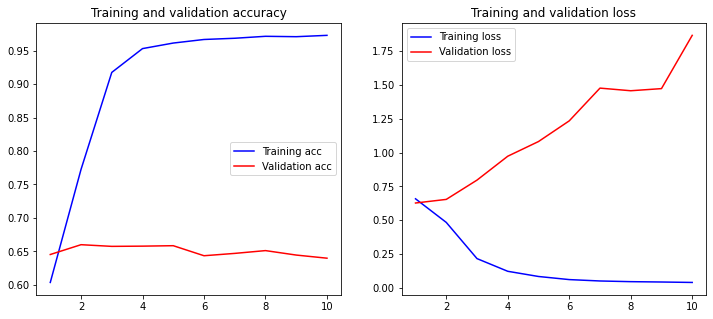

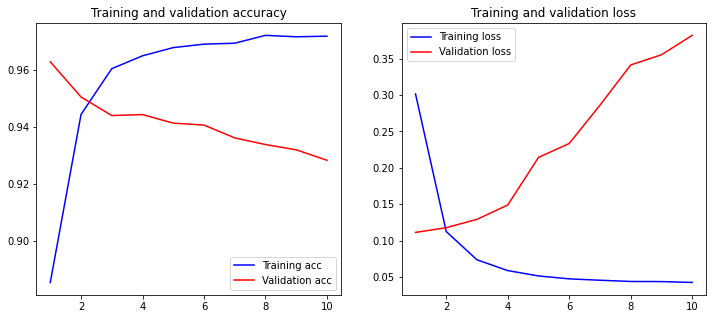

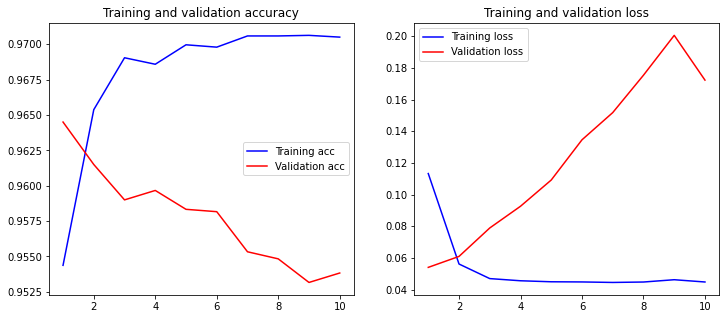

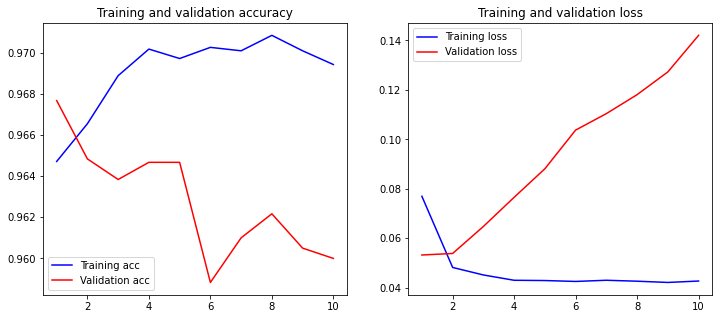

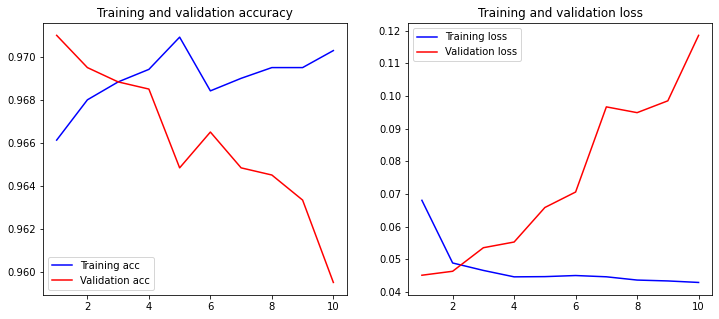

In [ ]:
 tic=time.perf_counter()
x=data
y=labels
embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/Amfstext/sg"
 
fn="Amfstext300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSFST300SG.png'
model= create_model(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSPFST300SG.h5'
final_train_test(model,x,y,svmd,10,50)
 
toc=time.perf_counter()
    
print(f"it takes {toc-tic:0.4f} seconds")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 216, 300)          33671400  
_________________________________________________________________
conv1d (Conv1D)              (None, 216, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 108, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               442496    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

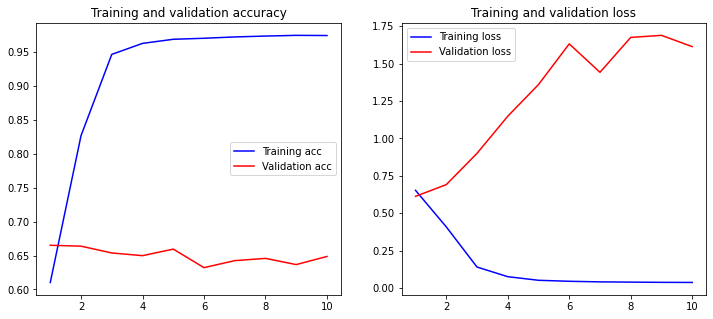

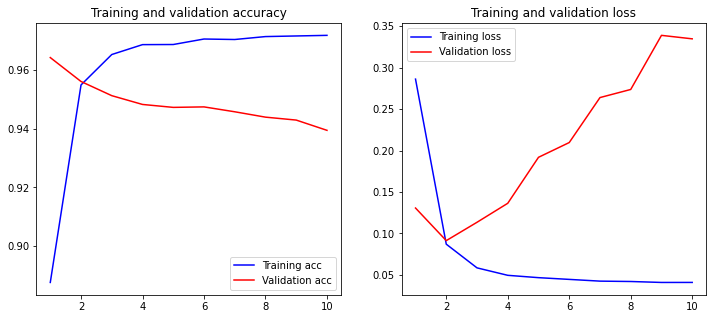

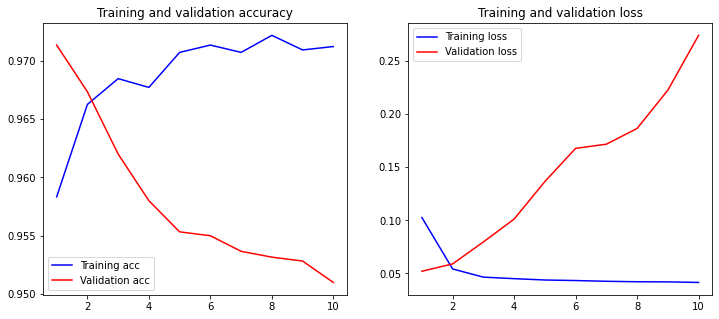

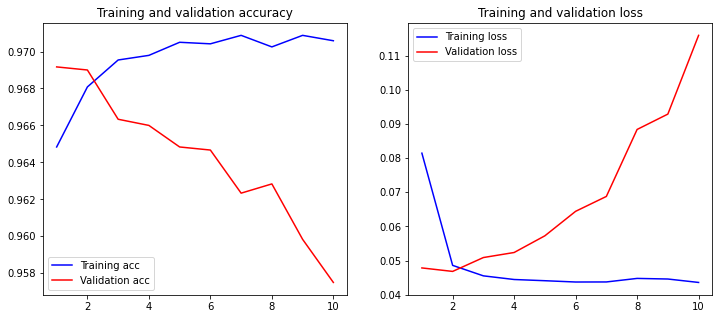

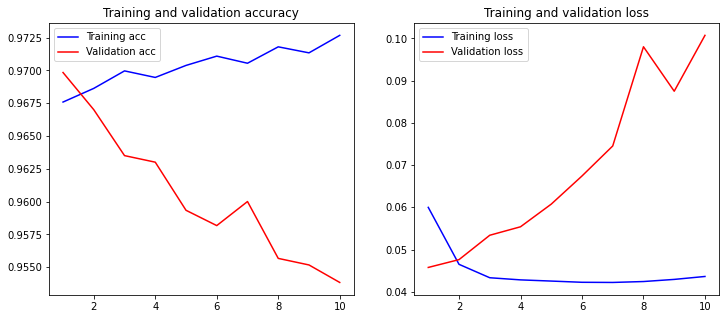

In [ ]:
 tic=time.perf_counter()
x=data
y=labels
embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/sg"
 
fn="AmW2vec300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSW2V300SG.png'
model= create_model(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSW2V300SG.h5'
final_train_test(model,x,y,svmd,10,50)
 
toc=time.perf_counter()
 
    
print(f"it takes {toc-tic:0.4f} seconds")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 216, 300)          33671400  
_________________________________________________________________
conv1d (Conv1D)              (None, 216, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 108, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               442496    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

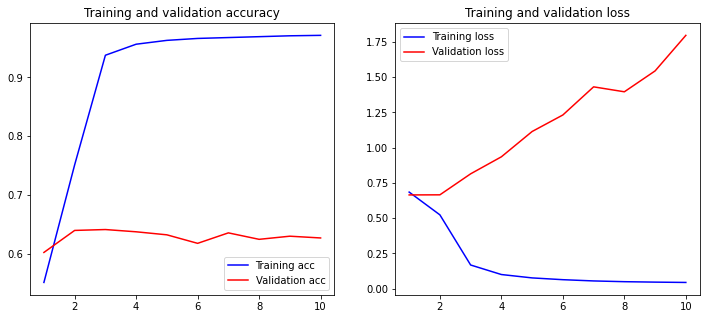

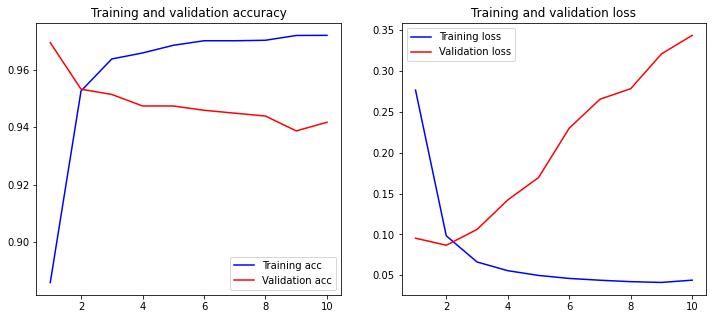

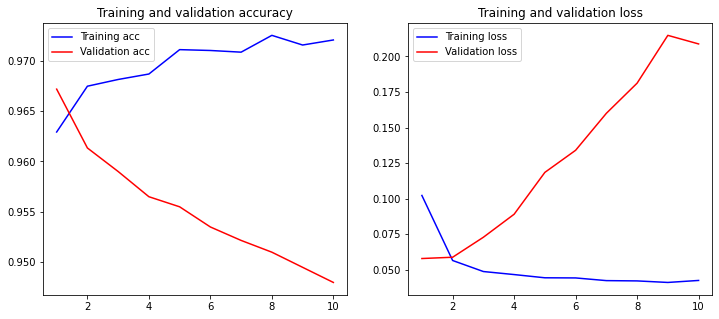

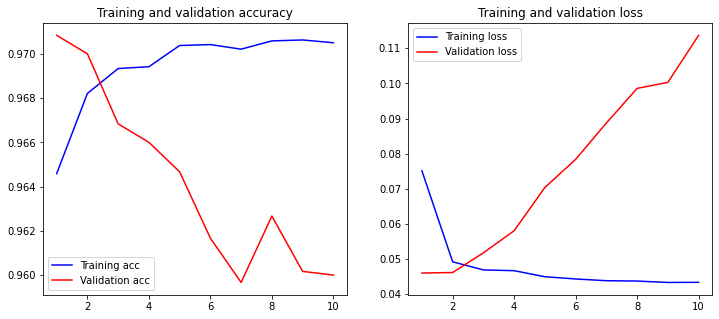

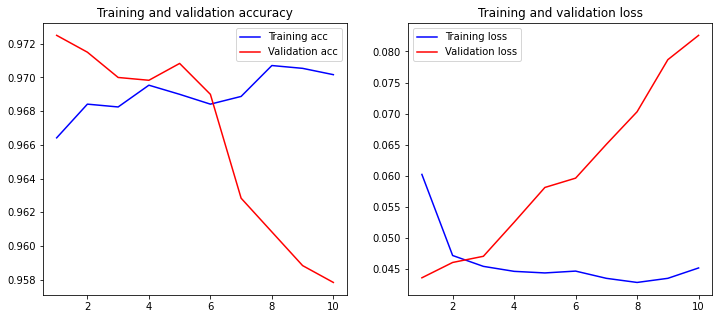

In [ ]:
 
embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/cbw"
 
fn="AmW2vec300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSW2V300CB.png'
model= create_model(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSW2V300CB.h5'
final_train_test(model,x,y,svmd,10,50)

In [ ]:
 from sklearn.metrics import confusion_matrix# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay


data=pd.read_csv('drive/MyDrive/FinalCode/FinalAmhPostsDataSet.tsv',header=None,delimiter='\t')
#data=pd.read_csv('drive/MyDrive/FinalCode/testAmhPosts.tsv',header=None,delimiter='\t')
data.columns=['Posts','Label']
data['Label']=data['Label'].fillna(0)
    
sentences=[readCmpAbbrWord(str(sen)) for sen in data.Posts]
sentences=[str(sen).replace('::','፡፡ ') for sen in sentences]
    
sentences=[str(sen).replace('፡፡','. ') for sen in sentences]
sentences=[trim_elongated(str(sen)) for sen in sentences]
sentences=[sentence_Amh(str(sen)) for sen in sentences]
sentences=[sentence_to_wordlist(str(sen)) for sen in sentences]
sentences1=sentences
 
#sentences1=NormalizedTokens(sentences1)
data['Text_Final']=[' '.join(sen) for sen in sentences]
#embedding_index=AmEmbeddingIndex() 
 
sentences=data['Text_Final'].values
labels=data['Label'].values
lbl=data['Label'].values
#labels_index = dict((x,i) for i,x in enumerate(set(labels)))
#labels = [labels_index[x] for x in labels] 
tokenizer = create_tokenizer(sentences)
 word_index = tokenizer.word_index       
sequences = tokenizer.texts_to_sequences(sentences)
maxlen = 216 
 
data = pad_sequences(sequences, maxlen)  
#model = load_model('/content/drive/MyDrive/FinalCode/FinalModel/AHSW2V300CBB.h5',compile=False)#content/drive/MyDrive/FinalCode/FinalModel/AHSPFST300CBB.h5', compile = False)
   # custom_objects={'f1_m': f1_m,'precision_m':precision_m,'recall_m':recall_m})
 
text_train, text_test, y_train, y_test = train_test_split(data, lbl, test_size=0.20,random_state=1000) 
ypred=model.predict(text_test)
ypred[ypred>0.5]=1
ypred[ypred<=0.5]=0
#cm=confusion_matrix(y_test,ypred)
#print(cm)
rslt=zip(lbl,ypred) 
#y_pred=model.predict(data)

In [ ]:
data=pd.read_csv('drive/MyDrive/FinalCode/FinalAmhPostsDataSet.tsv',header=None,delimiter='\t')
data.columns=['Posts','Label']

#data=pd.read_csv('drive/MyDrive/FinalCode/testAmhPosts.tsv',header=None,delimiter='\t')
data.columns=['Posts','Label']
data["Label"].fillna("0",inplace=True)   
sentences=[readCmpAbbrWord(str(sen)) for sen in data.Posts]
sentences=[str(sen).replace('::','፡፡ ') for sen in sentences]
    
sentences=[str(sen).replace('፡፡','. ') for sen in sentences]
sentences=[trim_elongated(str(sen)) for sen in sentences]
sentences=[sentence_Amh(str(sen)) for sen in sentences]
sentences=[sentence_to_wordlist(str(sen)) for sen in sentences]
sentences1=sentences
 
#sentences1=NormalizedTokens(sentences1)
data['Text_Final']=[' '.join(sen) for sen in sentences]
#embedding_index=AmEmbeddingIndex() 
 
sentences=data['Text_Final'].values
labels=data['Label'].values
labls=data['Label'].values

tokenizer = create_tokenizer(sentences)
 
      
sequences = tokenizer.texts_to_sequences(sentences)
maxlen = 216 #max(len(x) for x in sequences)
word_index = tokenizer.word_index       
print('Found %s unique tokens.' % len(word_index))
print('Sentence max length is:' + str(maxlen))
data = pad_sequences(sequences, maxlen)        

print('Shape of data tensor:', data.shape)      
print('Shape of label tensor:', labels.shape)

Found 112237 unique tokens.
Sentence max length is:216
Shape of data tensor: (30000, 216)
Shape of label tensor: (30000,)


In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

# Function to create model, required for KerasClassifier
def create_modelgs(optimizer='adam', neurons=32,dropout_rate=0.0, filters=32,kernel_size=3):
    # create model
    model = Sequential() 
    model.add(Embedding(112238, 300, input_length=216, 
                           trainable=True))    
    model.add(Conv1D(filters,kernel_size,activation='relu'))
       
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset

# split into input (X) and output (Y) variables
X = data
Y = labels
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.90, random_state=1000)

# create model
model = KerasClassifier(build_fn=create_modelgs, verbose=0)
# define the grid search parameters
kernel_size = [3,4,5]
filters = [32,64,128]
embed_dim=[50,150,250,300]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
neurons = [15,32,64]
vocab_size=len(word_index)+1
dropout_rate = [0.2, 0.3, 0.5]
param_grid = dict(kernel_size=kernel_size, filters=filters,optimizer=optimizer,neurons=neurons,dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 216, 300)          33671400  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 64)           96064     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

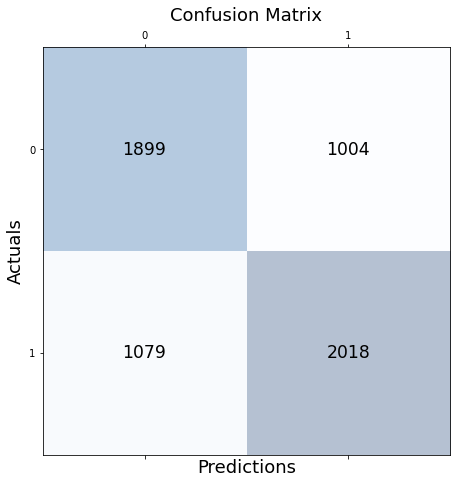

Epoch 1/10
188/188 [==============================] - 109s 577ms/step - loss: 0.2931 - accuracy: 0.8787 - f1_m: 0.8831 - precision_m: 0.8613 - recall_m: 0.9088 - val_loss: 0.1528 - val_accuracy: 0.9498 - val_f1_m: 0.9478 - val_precision_m: 0.9383 - val_recall_m: 0.9666
Epoch 2/10
188/188 [==============================] - 109s 578ms/step - loss: 0.2330 - accuracy: 0.9043 - f1_m: 0.9072 - precision_m: 0.8914 - recall_m: 0.9262 - val_loss: 0.1471 - val_accuracy: 0.9435 - val_f1_m: 0.9426 - val_precision_m: 0.9465 - val_recall_m: 0.9494
Epoch 3/10
188/188 [==============================] - 109s 578ms/step - loss: 0.1860 - accuracy: 0.9270 - f1_m: 0.9286 - precision_m: 0.9172 - recall_m: 0.9417 - val_loss: 0.1825 - val_accuracy: 0.9328 - val_f1_m: 0.9322 - val_precision_m: 0.9580 - val_recall_m: 0.9185
Epoch 4/10
188/188 [==============================] - 108s 577ms/step - loss: 0.1509 - accuracy: 0.9410 - f1_m: 0.9420 - precision_m: 0.9363 - recall_m: 0.9491 - val_loss: 0.2154 - val_accur

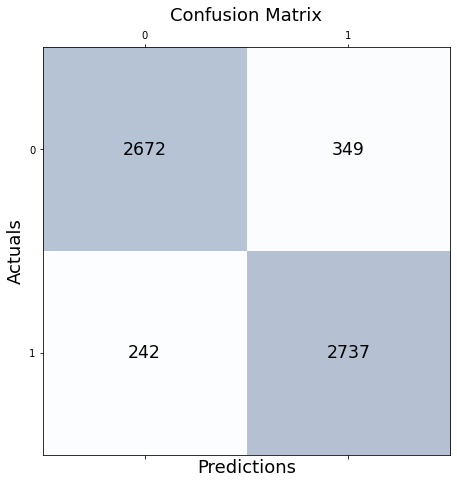

Epoch 1/10
188/188 [==============================] - 108s 577ms/step - loss: 0.1608 - accuracy: 0.9460 - f1_m: 0.9469 - precision_m: 0.9385 - recall_m: 0.9565 - val_loss: 0.0731 - val_accuracy: 0.9678 - val_f1_m: 0.9664 - val_precision_m: 0.9498 - val_recall_m: 0.9910
Epoch 2/10
188/188 [==============================] - 109s 579ms/step - loss: 0.1270 - accuracy: 0.9518 - f1_m: 0.9525 - precision_m: 0.9430 - recall_m: 0.9632 - val_loss: 0.0624 - val_accuracy: 0.9670 - val_f1_m: 0.9668 - val_precision_m: 0.9615 - val_recall_m: 0.9786
Epoch 3/10
188/188 [==============================] - 109s 578ms/step - loss: 0.1046 - accuracy: 0.9574 - f1_m: 0.9579 - precision_m: 0.9499 - recall_m: 0.9670 - val_loss: 0.0720 - val_accuracy: 0.9647 - val_f1_m: 0.9648 - val_precision_m: 0.9651 - val_recall_m: 0.9711
Epoch 4/10
188/188 [==============================] - 109s 579ms/step - loss: 0.0929 - accuracy: 0.9594 - f1_m: 0.9601 - precision_m: 0.9529 - recall_m: 0.9681 - val_loss: 0.0808 - val_accur

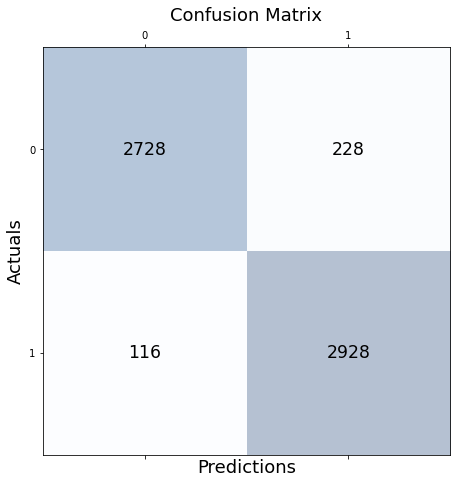

Epoch 1/10
188/188 [==============================] - 109s 577ms/step - loss: 0.0961 - accuracy: 0.9598 - f1_m: 0.9608 - precision_m: 0.9457 - recall_m: 0.9769 - val_loss: 0.0478 - val_accuracy: 0.9778 - val_f1_m: 0.9764 - val_precision_m: 0.9661 - val_recall_m: 0.9917
Epoch 2/10
188/188 [==============================] - 109s 577ms/step - loss: 0.0804 - accuracy: 0.9603 - f1_m: 0.9611 - precision_m: 0.9435 - recall_m: 0.9800 - val_loss: 0.0589 - val_accuracy: 0.9745 - val_f1_m: 0.9733 - val_precision_m: 0.9670 - val_recall_m: 0.9844
Epoch 3/10
188/188 [==============================] - 108s 576ms/step - loss: 0.0724 - accuracy: 0.9624 - f1_m: 0.9634 - precision_m: 0.9447 - recall_m: 0.9834 - val_loss: 0.0595 - val_accuracy: 0.9720 - val_f1_m: 0.9712 - val_precision_m: 0.9595 - val_recall_m: 0.9896
Epoch 4/10
188/188 [==============================] - 109s 579ms/step - loss: 0.0665 - accuracy: 0.9630 - f1_m: 0.9640 - precision_m: 0.9458 - recall_m: 0.9835 - val_loss: 0.0722 - val_accur

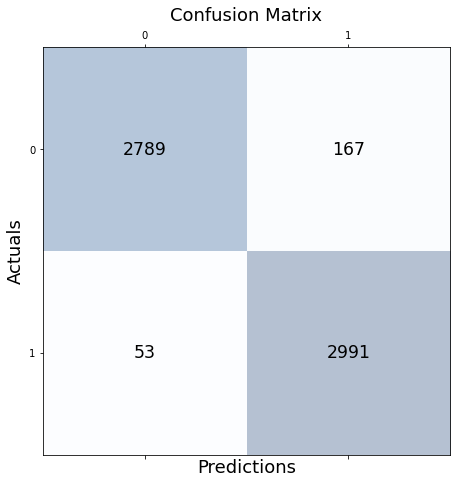

Epoch 1/10
188/188 [==============================] - 107s 569ms/step - loss: 0.0756 - accuracy: 0.9635 - f1_m: 0.9645 - precision_m: 0.9428 - recall_m: 0.9878 - val_loss: 0.0469 - val_accuracy: 0.9723 - val_f1_m: 0.9711 - val_precision_m: 0.9537 - val_recall_m: 0.9963
Epoch 2/10
188/188 [==============================] - 106s 566ms/step - loss: 0.0643 - accuracy: 0.9649 - f1_m: 0.9659 - precision_m: 0.9444 - recall_m: 0.9889 - val_loss: 0.0532 - val_accuracy: 0.9715 - val_f1_m: 0.9700 - val_precision_m: 0.9595 - val_recall_m: 0.9870
Epoch 3/10
188/188 [==============================] - 106s 566ms/step - loss: 0.0624 - accuracy: 0.9650 - f1_m: 0.9660 - precision_m: 0.9444 - recall_m: 0.9893 - val_loss: 0.0583 - val_accuracy: 0.9687 - val_f1_m: 0.9672 - val_precision_m: 0.9536 - val_recall_m: 0.9884
Epoch 4/10
188/188 [==============================] - 107s 567ms/step - loss: 0.0604 - accuracy: 0.9655 - f1_m: 0.9664 - precision_m: 0.9453 - recall_m: 0.9889 - val_loss: 0.0575 - val_accur

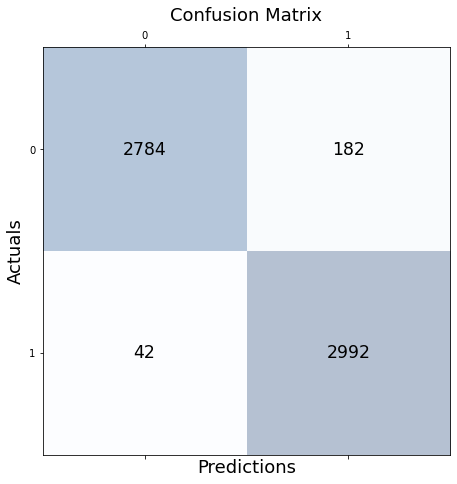

Average training accuracy is: 0.9686500072479248
Average training precision is: 0.9000775694847107
Average training recall is: 0.9330251932144165
Average training f1score is: 0.9096398830413819
Average testing accuracy is: 0.8845999956130981
Average testing precision is: 0.8535938501358032
Average testing recall is: 0.8891994833946228
Average testing f1score is: 0.8586776971817016


In [ ]:
from sklearn.model_selection import KFold

word_index = tokenizer.word_index  
x=data
y=labels
kf=KFold(n_splits=5,shuffle=True)

embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/cbw"

fn="AmW2vec300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSW2V300CBCM.png'
model= create_model1(vocab_size, maxlen,embedding_dim,embmtrx,mpng)

svmd='drive/MyDrive/FinalCode/FinalModel/AHSW2V300CBCM.h5'

training_error = []
training_accuracy = []
testing_error = []
testing_accuracy = []
training_recall = []
training_precision = []
training_f1score = []
testing_recall = []
testing_precision = []
testing_f1score = []
for train_index,test_index in kf.split(x):
    #model=define_model(vocab_size, maxlen,embedding_dim)
     # divide the data into train and test
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y[train_index],y[test_index]
        history =model.fit(x_train, y_train, verbose=True, validation_data=(x_test, y_test),epochs=10, batch_size=128)    #get the prediction for train and test data 
        train_data_pred = model.predict(x_train)
        test_data_pred = model.predict(x_test)
     #appending the errors to the list
        training_error.append(mean_absolute_error(y_train,train_data_pred))
        testing_error.append(mean_absolute_error(y_test,test_data_pred))
     #appending the accuracy to the list
    
    

        loss, accuracy,f1_score,precision,recall = model.evaluate(x_train, y_train, verbose=True)
        print("Training Accuracy: {:.4f}".format(accuracy))
        print("Training Precision: {:.4f}".format(precision))
        print("Training Recall: {:.4f}".format(recall))    
        print("Training F1_Score: {:.4f}".format(f1_score)) 
        training_accuracy.append(accuracy) 
        training_recall.append(recall)        
        training_precision.append(precision)
        training_f1score.append(f1_score)   
        loss, accuracy,f1_score,precision,recall  = model.evaluate(x_test, y_test, verbose=True)
        print("Testing Accuracy:  {:.4f}".format(accuracy))
        print("Testing Precision: {:.4f}".format(precision))
        print("Testing Recall: {:.4f}".format(recall))    
        print("Testing F1_Score: {:.4f}".format(f1_score))   
        testing_accuracy.append(accuracy) 
        testing_recall.append(recall)            
        testing_precision.append(precision)
        testing_f1score.append(f1_score)           
        ypred=test_data_pred #  model .predict(x_test)
        ypred[ypred>0.5]=1
        ypred[ypred<=0.5]=0
        conf_matrix  =confusion_matrix(y_test,ypred)
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(conf_matrix.shape[1]):
            for j in range(conf_matrix.shape[0]):
                ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
print("Average training accuracy is:",mean(training_accuracy))
print("Average training precision is:",mean(training_precision))
print("Average training recall is:",mean(training_recall))
print("Average training f1score is:",mean(training_f1score))

print("Average testing accuracy is:",mean(testing_accuracy))
print("Average testing precision is:",mean(testing_precision))
print("Average testing recall is:",mean(testing_recall))
print("Average testing f1score is:",mean(testing_f1score))
model.save(svmd)

In [ ]:
embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/sg"

fn="AmW2vec300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSW2V300SGBCM.png'
model= create_model1(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSW2V300SGBCM.h5'
final_train_test(model,x,y,svmd,10,128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 216, 300)          33671400  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 64)           96064     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

KeyboardInterrupt: ignored

Found 9477 unique tokens.
Sentence max length is:216


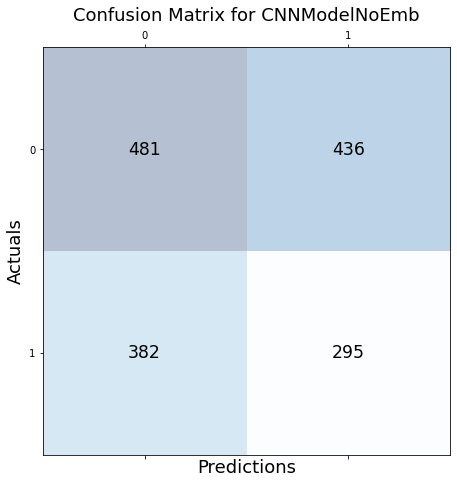

In [ ]:

from sklearn.metrics import confusion_matrix# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay
data=pd.read_csv('drive/MyDrive/FinalCode/testAmhPosts.tsv',header=None,delimiter='\t')
data.columns=['Posts','Label']
data.dropna()
sentences=[readCmpAbbrWord(str(sen)) for sen in data.Posts]
sentences=[str(sen).replace('::','፡፡ ') for sen in sentences]
    
sentences=[str(sen).replace('፡፡','. ') for sen in sentences]
sentences=[trim_elongated(str(sen)) for sen in sentences]
sentences=[sentence_Amh(str(sen)) for sen in sentences]
sentences=[sentence_to_wordlist(str(sen)) for sen in sentences]
sentences1=sentences

#sentences1=NormalizedTokens(sentences1)
data['Text_Final']=[' '.join(sen) for sen in sentences]
#embedding_index=AmEmbeddingIndex() 
nv=float("NaN")
data.replace("",nv,inplace=True)
data1=data.dropna()
sentences=data1['Text_Final'].values

#data["Label"].replace([np.inf, -np.inf], np.nan, inplace=True)
#data.dropna(subset=1, inplace=True)


#sentences=[str(cld) for cld in data1['Text_Final']]

labels=data1['Label'].values

# x=dict((x,i) for i,x in enumerate(set(labels)))
#labels=[lbix[x] for x in labels]
tokenizer = create_tokenizer(sentences)

      
sequences = tokenizer.texts_to_sequences(sentences)
maxlen =216 #max(len(x) for x in sequences)
word_index = tokenizer.word_index       
print('Found %s unique tokens.' % len(word_index))
print('Sentence max length is:' + str(maxlen))
data = pad_sequences(sequences, maxlen)   
 #/content/drive/MyDrive/FinalCode/FinalModel/AHSPFST300SGB.h5  
# /content/drive/MyDrive/FinalCode/FinalModel/CNNModel300DWV.h5
model = load_model('/content/drive/MyDrive/FinalCode/FinalModel/CNNModel300DWV.h5',compile=False)
ypred=model.predict(data)
ypred[ypred>0.5]=1
ypred[ypred<=0.5]=0
conf_matrix  =confusion_matrix(labels,ypred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for CNNModelNoEmb', fontsize=18)
plt.show()
#print(len(data))
#print(cm)

In [ ]:
data1.describe()

NameError: ignored

In [ ]:
 
print("Acc.Label","Predicted")
for yt,yp in rslt:
    print(yt,yp)

Acc.Label Predicted
1.0 [1.]
1.0 [1.]
1.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
1.0 [0.]
1.0 [1.]
1.0 [1.]
0.0 [0.]
1.0 [0.]
0.0 [0.]
0.0 [0.]
1.0 [0.]
0.0 [0.]
1.0 [1.]
0.0 [0.]
0.0 [0.]
1.0 [0.]
1.0 [1.]
1.0 [0.]
0.0 [0.]
0.0 [1.]
0.0 [0.]
1.0 [1.]
0.0 [1.]
0.0 [1.]
0.0 [1.]
0.0 [1.]
0.0 [0.]
0.0 [1.]
1.0 [1.]
0.0 [0.]
1.0 [1.]
1.0 [0.]
1.0 [0.]
0.0 [0.]
0.0 [1.]
0.0 [0.]
1.0 [0.]
0.0 [1.]
1.0 [0.]
1.0 [1.]
1.0 [0.]
1.0 [1.]
1.0 [0.]
1.0 [1.]
0.0 [1.]
0.0 [1.]
0.0 [0.]
0.0 [0.]
1.0 [0.]
0.0 [1.]
0.0 [1.]
0.0 [1.]
1.0 [1.]
0.0 [0.]
1.0 [1.]
0.0 [0.]
1.0 [0.]
0.0 [1.]
0.0 [1.]
0.0 [1.]
0.0 [1.]
0.0 [1.]
0.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
0.0 [1.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [1.]
0.0 [0.]
1.0 [0.]
1.0 [1.]
1.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
1.0 [0.]
0.0 [1.]
1.0 [0.]
0.0 [1.]
0.0 [0.]
1.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
1.0 [0.]
1.0 [1.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [1.]
0.0 [0.]
0.0 [1.]
1.0 [0.]
1.0 [0.]
1.0 [0.]
0.0 [0.]
0.0 [1.]
0.0 [0.]
0.0 [0.]

In [ ]:
 data=pd.read_csv('drive/MyDrive/FinalCode/testAmhPosts.tsv',header=None,delimiter='\t')
data.columns=['Posts','Label']
data[1985]

KeyError: ignored

In [ ]:
 
embedding_dim = 300
vocab_size=len(word_index)
dr="drive/MyDrive/FinalCode/FinalTrained/Amfstext/cbw"
 
fn="Amfstext300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
 
nonzero_elements = np.count_nonzero(np.count_nonzero(embmtrx  , axis=1))
embCovr=nonzero_elements / vocab_size
print(embCovr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


0.9999109028217076


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 216, 300)          33671400  
_________________________________________________________________
conv1d (Conv1D)              (None, 216, 64)           96064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

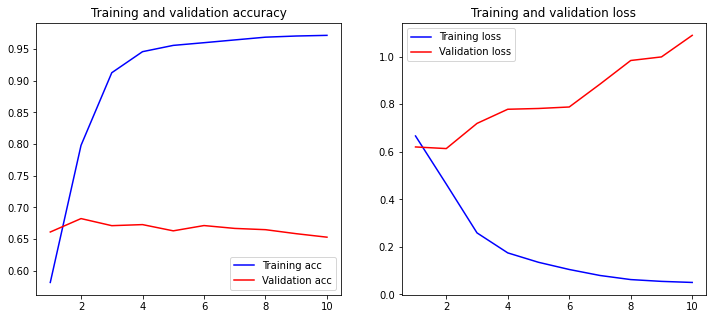

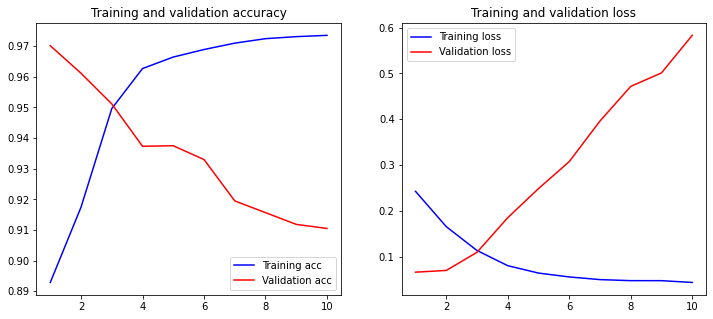

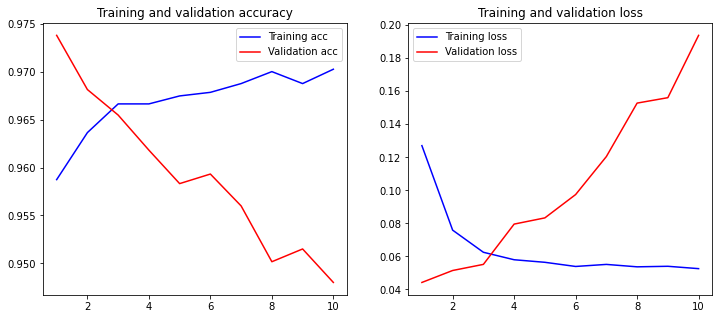

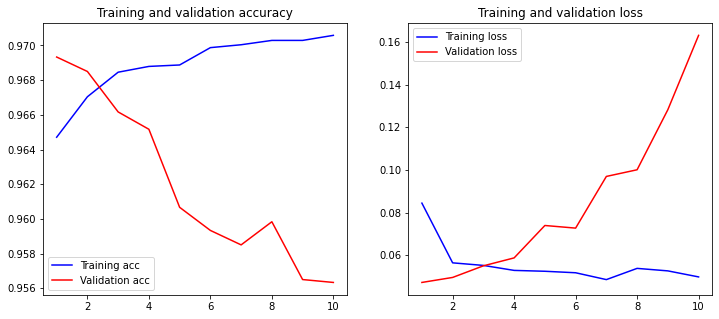

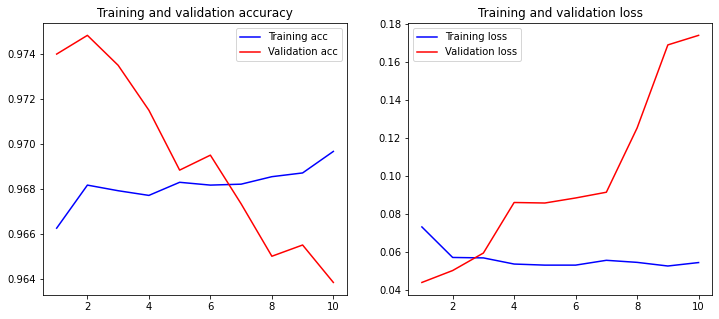

In [ ]:
 embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/Amfstext/sg"
 
fn="Amfstext300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
 
mpng='drive/MyDrive/FinalCode/FinalModel/CNNModel300DWV.png'
model= create_model(vocab_size, maxlen,embedding_dim,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/CNNModel300DWV.h5'
final_train_test(model,x,y,svmd,10,128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 216, 300)          33671400  
_________________________________________________________________
conv1d (Conv1D)              (None, 216, 64)           96064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

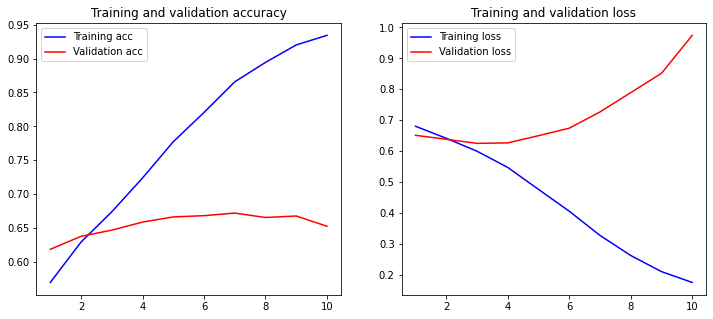

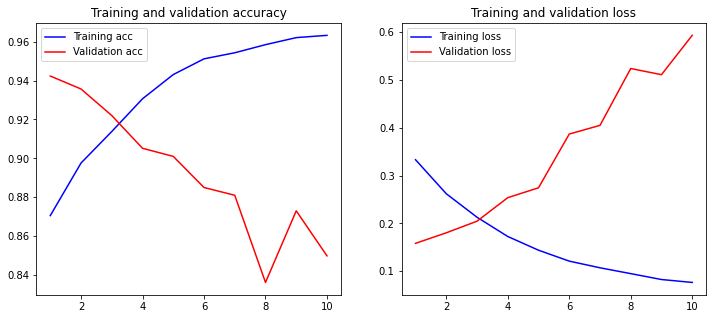

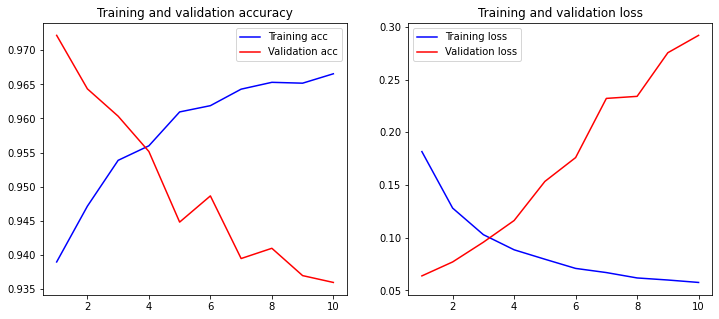

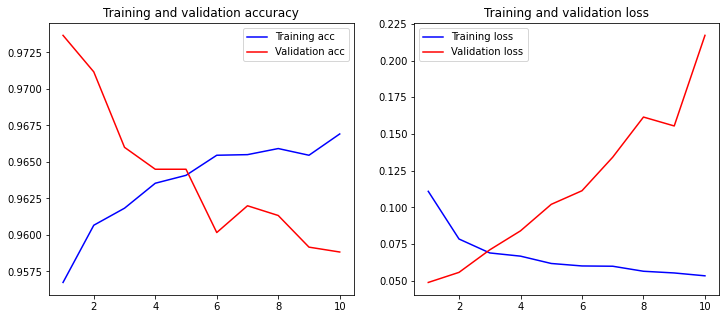

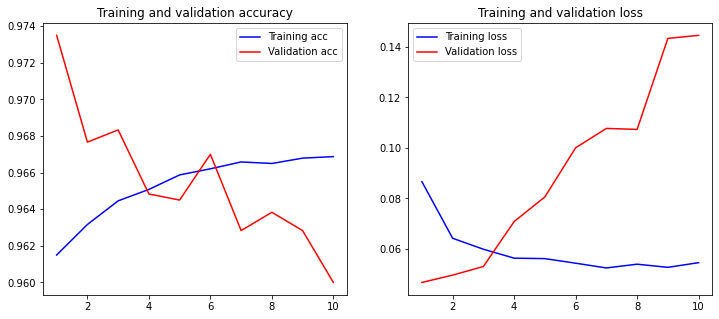

In [ ]:
 
embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/Amfstext/sg"
 
fn="Amfstext300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSFST300SGB.png'
model= create_model1(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSPFST300SGB.h5'
final_train_test(model,x,y,svmd,10,128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 216, 300)          33671400  
_________________________________________________________________
conv1d (Conv1D)              (None, 216, 64)           96064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

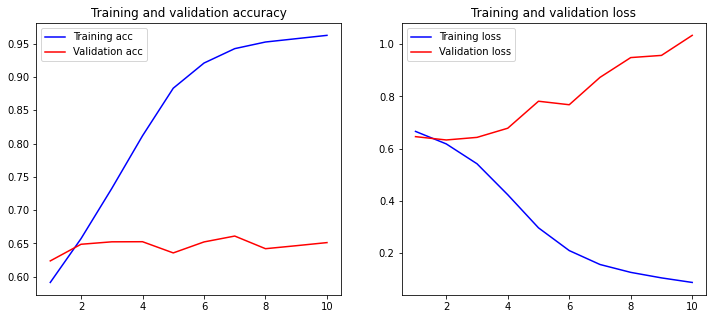

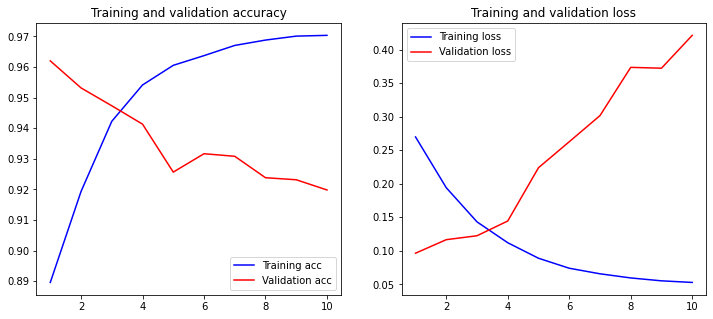

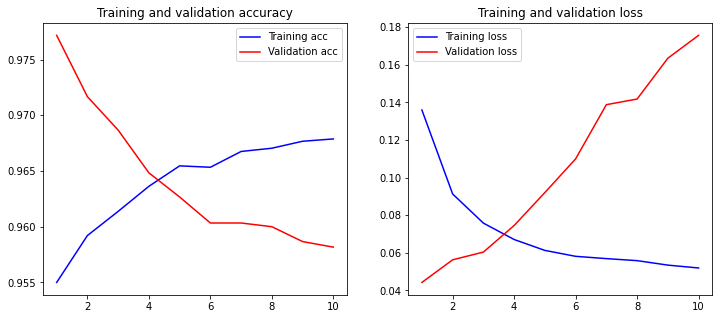

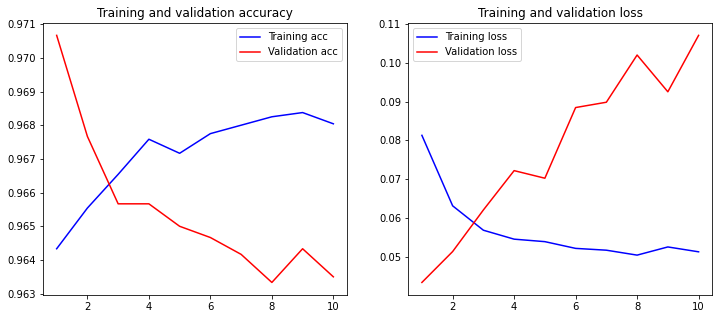

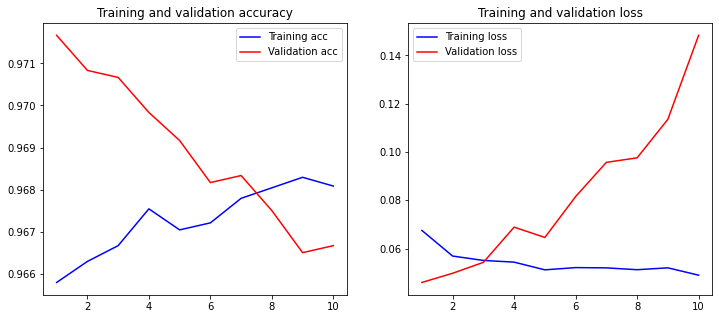

In [ ]:
 embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/sg"
 
fn="AmW2vec300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSW2V300SGB.png'
model= create_model1(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSW2V300SGB.h5'
final_train_test(model,x,y,svmd,10,128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 216, 300)          33671400  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 64)           96064     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

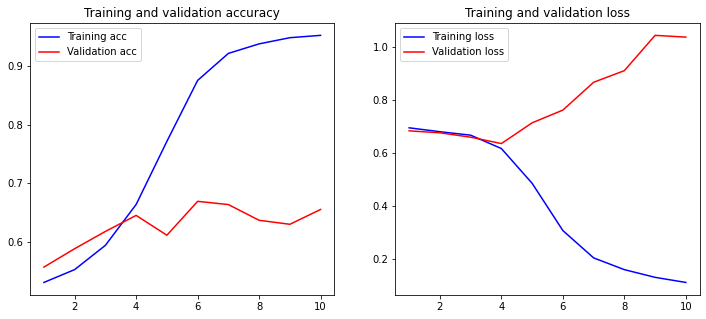

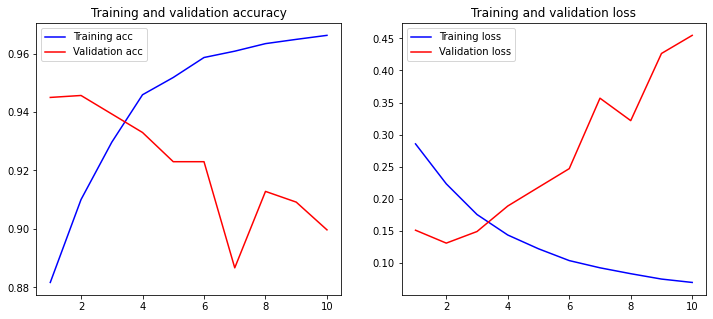

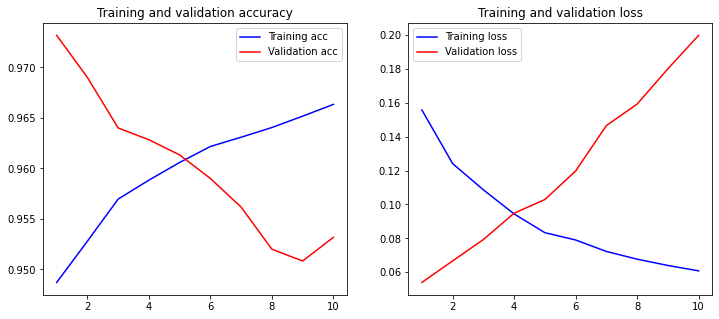

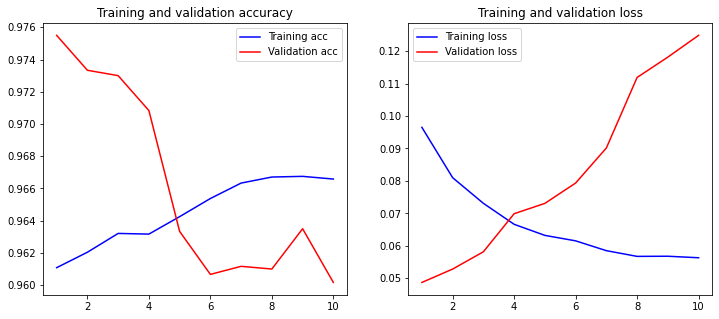

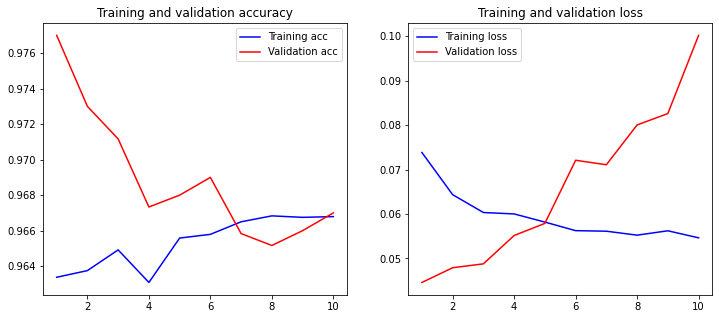

In [ ]:
 embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/cbw"
 
fn="AmW2vec300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSW2V300CBB.png'
model= create_model1(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSW2V300CBB.h5'
final_train_test(model,x,y,svmd,10,128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 216, 300)          33671400  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 64)           96064     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

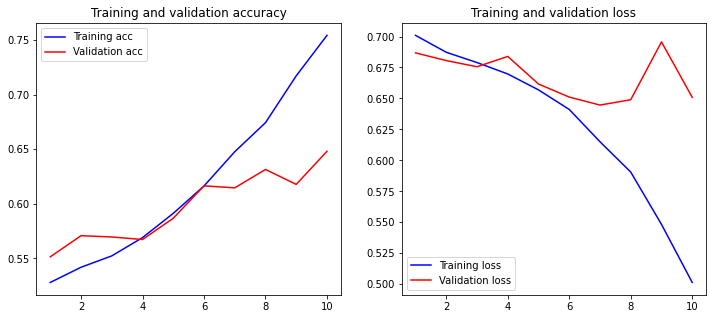

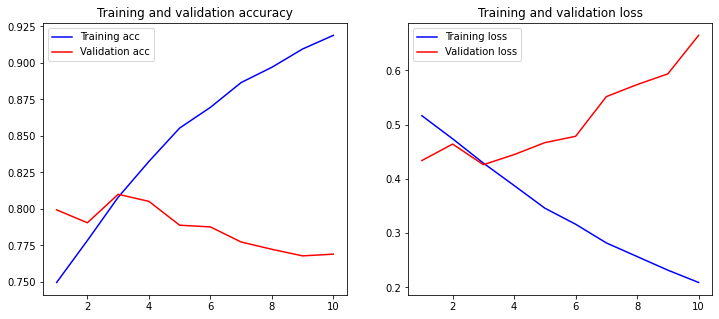

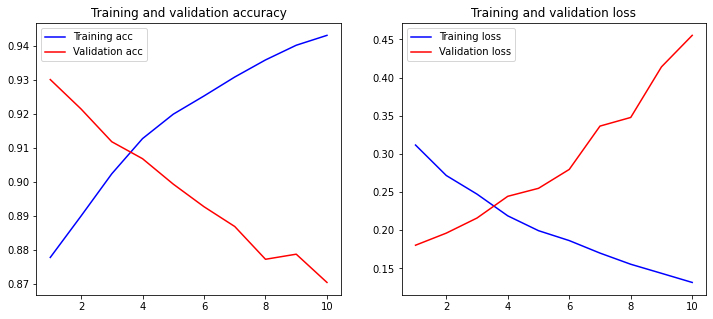

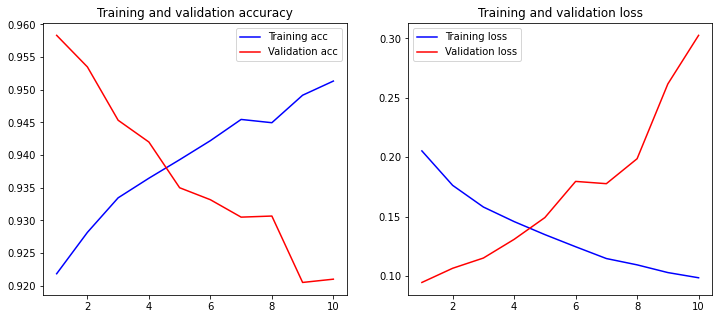

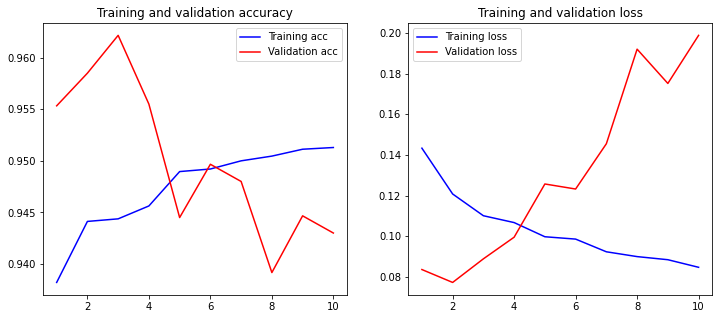

In [ ]:
 embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/Amfstext/cbw"
 
fn="Amfstext300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSFST300CBB.png'
model= create_model1(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSPFST300CBB.h5'
final_train_test(model,x,y,svmd,10,128)

In [ ]:
from tensorflow import keras
opt1=keras.optimizers.RMSprop(learning_rate=0.001)
do=0.5
epoch=20
batch=128

,Posts,Label
0,አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...,0
1,እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደ...,0
2,የአማራ ህዝብ በአእምሮ ክንፉ ያልበረረበት ጥበብና ፍልስፍና ያልከፈተው የ...,0
3,ከአማራ ህዝብ የሀገሪቱ ዘርፈ ብዙ እውቀት መንጭቶ የሞላበትከሙላቱም በመል...,0
4,ዛሬ በየትኛውም መለኪያ ይሁን መመዘኛ ኢትዮጵያዊነት የሚንፀባረቀው በአማራ...,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 216, 300)          3356400   
_________________________________________________________________
conv1d (Conv1D)              (None, 216, 64)           96064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

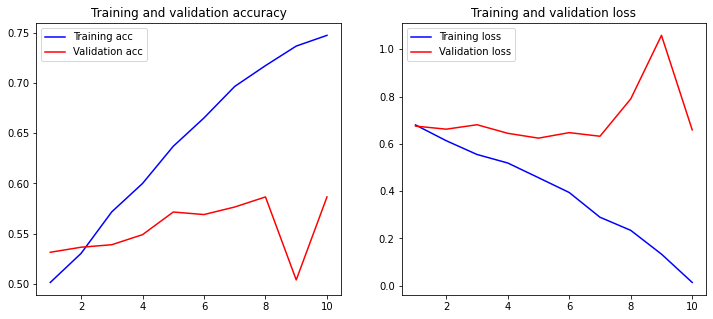

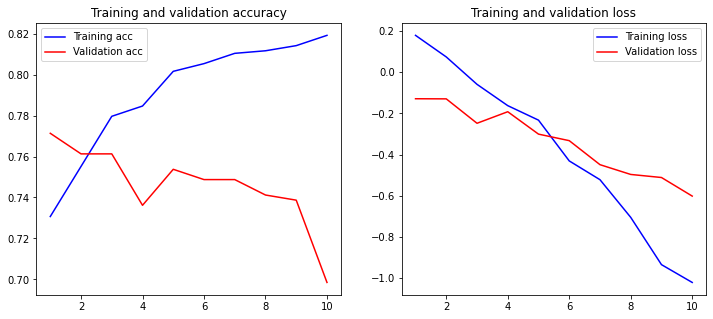

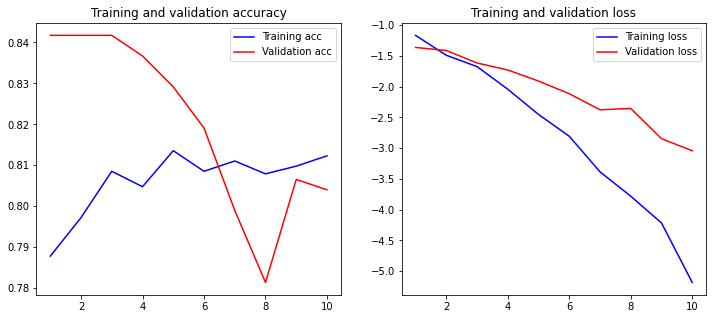

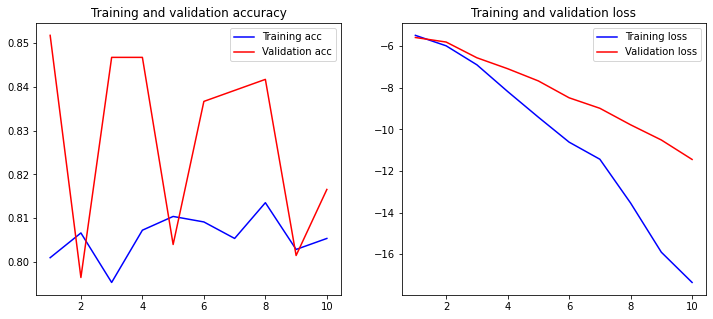

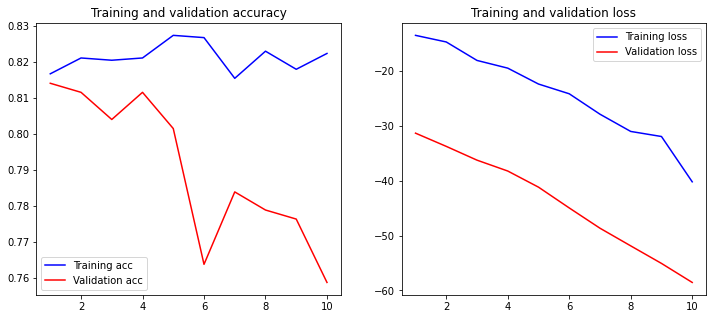

In [ ]:
embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/sg"

fn="AmW2vec300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSW2V300SGBDS2.png'
model= create_model1(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSW2V300SGBDS2.h5'
final_train_test(model,x,y,svmd,10,128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 216, 300)          3356400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 64)           96064     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

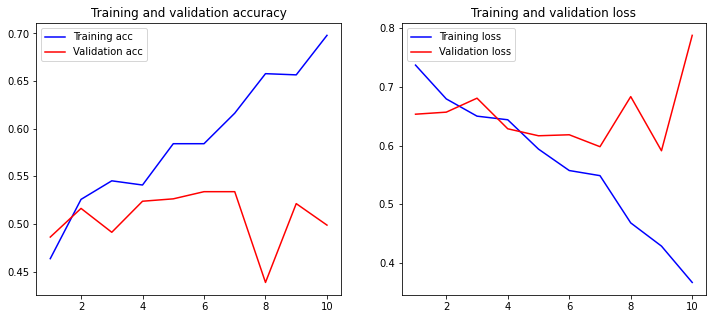

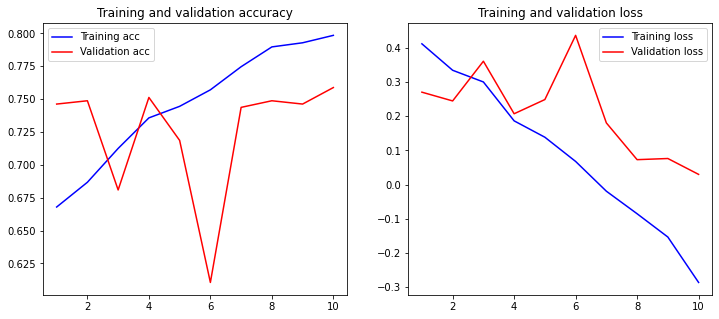

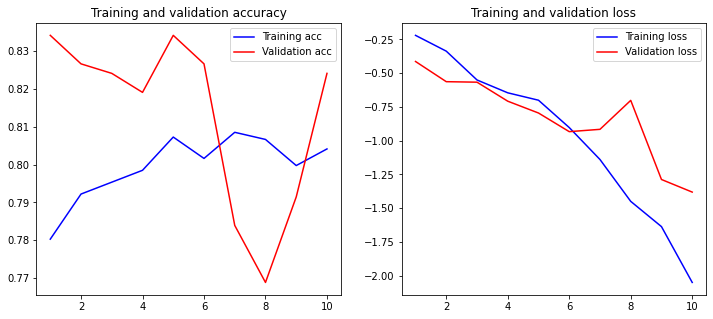

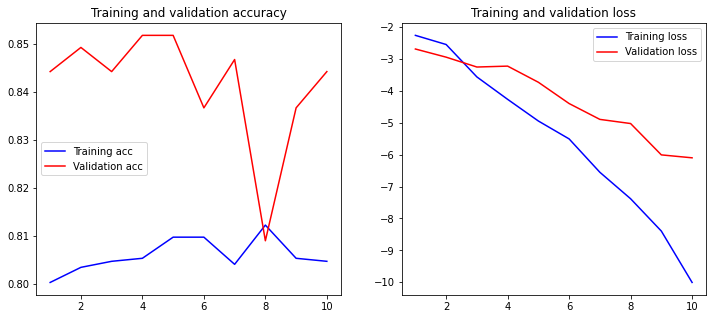

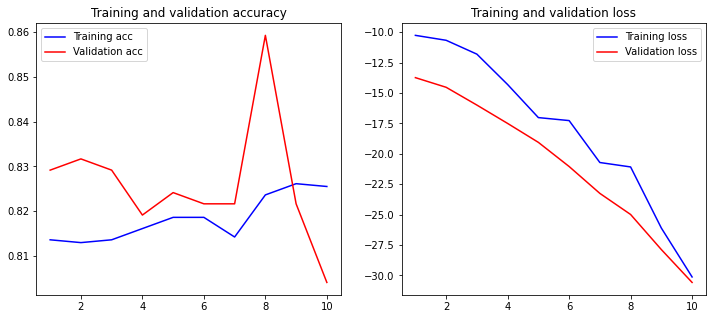

In [ ]:
embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/cbw"

fn="AmW2vec300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSW2V300CBBDS2.png'
model= create_model1(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSW2V300CBBDS2.h5'
final_train_test(model,x,y,svmd,10,128)

In [ ]:
from sklearn.metrics import confusion_matrix# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay


data1=pd.read_csv('drive/MyDrive/FinalCode/FinalAmhPostsDataSet.tsv',header=None,delimiter='\t')
data2=pd.read_csv('drive/MyDrive/FinalCode/testAmhPosts.tsv',header=None,delimiter='\t')
data0=pd.concat([data1, data2])

data=preprocess_data(data0)
#data00=preprocess_data(data2)
sentences=data['Text_Final'].values

#data["Label"].replace([np.inf, -np.inf], np.nan, inplace=True)
#data.dropna(subset=1, inplace=True)


#sentences=[str(cld) for cld in data1['Text_Final']]

labels=data['Label'].values

# x=dict((x,i) for i,x in enumerate(set(labels)))
#labels=[lbix[x] for x in labels]
tokenizer = create_tokenizer(sentences)

      
sequences = tokenizer.texts_to_sequences(sentences)
maxlen =216 #max(len(x) for x in sequences)
word_index = tokenizer.word_index       
print('Found %s unique tokens.' % len(word_index))
print('Sentence max length is:' + str(maxlen))
data = pad_sequences(sequences, maxlen)

Found 116018 unique tokens.
Sentence max length is:216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 216, 300)          34805700  
_________________________________________________________________
conv1d (Conv1D)              (None, 216, 64)           96064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

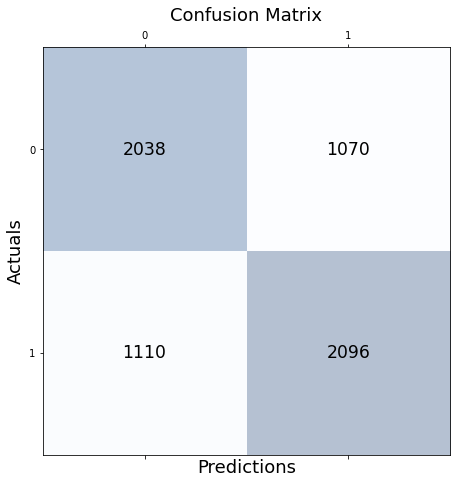

Epoch 1/10
198/198 [==============================] - 118s 594ms/step - loss: 0.2714 - accuracy: 0.8846 - f1_m: 0.8827 - precision_m: 0.8997 - recall_m: 0.8697 - val_loss: 0.1084 - val_accuracy: 0.9618 - val_f1_m: 0.9640 - val_precision_m: 0.9728 - val_recall_m: 0.9597
Epoch 2/10
198/198 [==============================] - 118s 597ms/step - loss: 0.2026 - accuracy: 0.9146 - f1_m: 0.9136 - precision_m: 0.9210 - recall_m: 0.9090 - val_loss: 0.1019 - val_accuracy: 0.9579 - val_f1_m: 0.9575 - val_precision_m: 0.9585 - val_recall_m: 0.9626
Epoch 3/10
198/198 [==============================] - 118s 596ms/step - loss: 0.1505 - accuracy: 0.9369 - f1_m: 0.9369 - precision_m: 0.9404 - recall_m: 0.9349 - val_loss: 0.1178 - val_accuracy: 0.9520 - val_f1_m: 0.9528 - val_precision_m: 0.9536 - val_recall_m: 0.9592
Epoch 4/10
198/198 [==============================] - 117s 592ms/step - loss: 0.1184 - accuracy: 0.9520 - f1_m: 0.9516 - precision_m: 0.9595 - recall_m: 0.9448 - val_loss: 0.1568 - val_accur

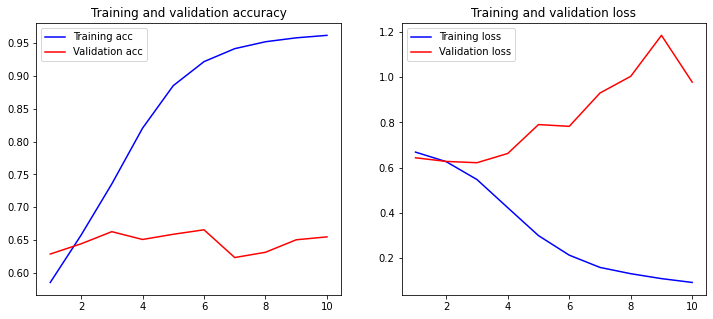

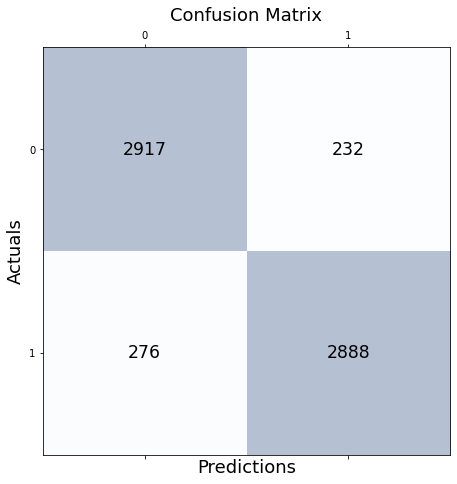

Epoch 1/10
198/198 [==============================] - 117s 592ms/step - loss: 0.1338 - accuracy: 0.9547 - f1_m: 0.9538 - precision_m: 0.9712 - recall_m: 0.9379 - val_loss: 0.0543 - val_accuracy: 0.9747 - val_f1_m: 0.9741 - val_precision_m: 0.9804 - val_recall_m: 0.9704
Epoch 2/10
198/198 [==============================] - 118s 596ms/step - loss: 0.0949 - accuracy: 0.9598 - f1_m: 0.9590 - precision_m: 0.9789 - recall_m: 0.9407 - val_loss: 0.0579 - val_accuracy: 0.9694 - val_f1_m: 0.9705 - val_precision_m: 0.9801 - val_recall_m: 0.9650
Epoch 3/10
198/198 [==============================] - 118s 596ms/step - loss: 0.0774 - accuracy: 0.9630 - f1_m: 0.9621 - precision_m: 0.9843 - recall_m: 0.9415 - val_loss: 0.0685 - val_accuracy: 0.9669 - val_f1_m: 0.9680 - val_precision_m: 0.9830 - val_recall_m: 0.9581
Epoch 4/10
198/198 [==============================] - 118s 597ms/step - loss: 0.0681 - accuracy: 0.9657 - f1_m: 0.9650 - precision_m: 0.9861 - recall_m: 0.9452 - val_loss: 0.0786 - val_accur

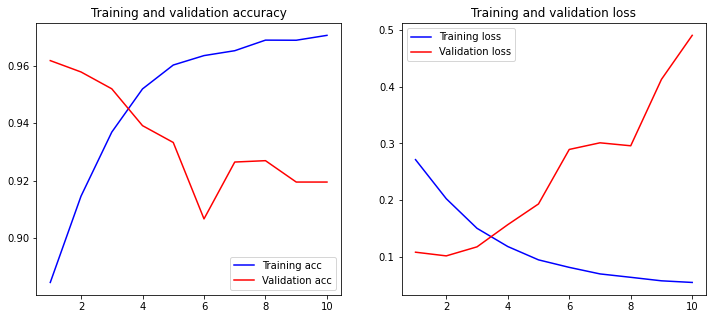

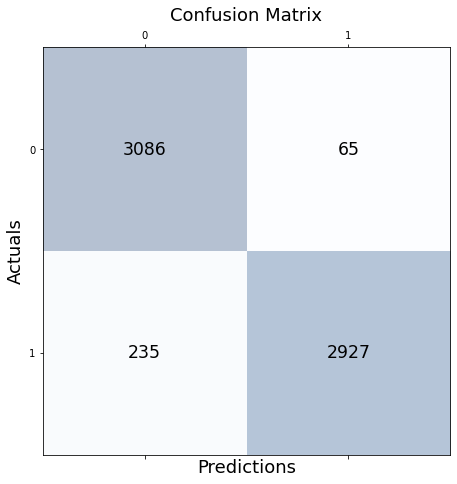

Epoch 1/10
198/198 [==============================] - 123s 619ms/step - loss: 0.0827 - accuracy: 0.9637 - f1_m: 0.9628 - precision_m: 0.9896 - recall_m: 0.9378 - val_loss: 0.0413 - val_accuracy: 0.9759 - val_f1_m: 0.9763 - val_precision_m: 0.9937 - val_recall_m: 0.9624
Epoch 2/10
198/198 [==============================] - 121s 612ms/step - loss: 0.0641 - accuracy: 0.9655 - f1_m: 0.9648 - precision_m: 0.9919 - recall_m: 0.9396 - val_loss: 0.0464 - val_accuracy: 0.9734 - val_f1_m: 0.9738 - val_precision_m: 0.9935 - val_recall_m: 0.9589
Epoch 3/10
198/198 [==============================] - 126s 638ms/step - loss: 0.0583 - accuracy: 0.9663 - f1_m: 0.9656 - precision_m: 0.9934 - recall_m: 0.9398 - val_loss: 0.0504 - val_accuracy: 0.9729 - val_f1_m: 0.9731 - val_precision_m: 0.9949 - val_recall_m: 0.9565
Epoch 4/10
198/198 [==============================] - 125s 632ms/step - loss: 0.0576 - accuracy: 0.9682 - f1_m: 0.9671 - precision_m: 0.9954 - recall_m: 0.9411 - val_loss: 0.0580 - val_accur

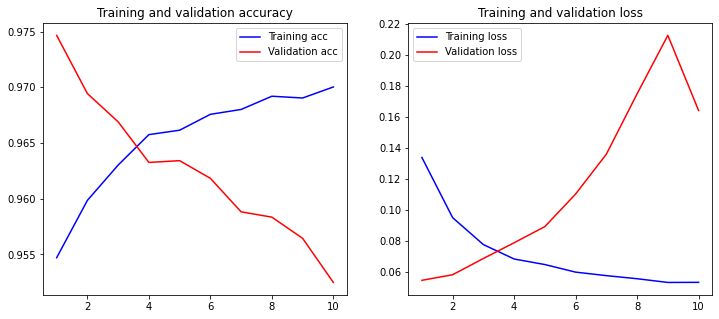

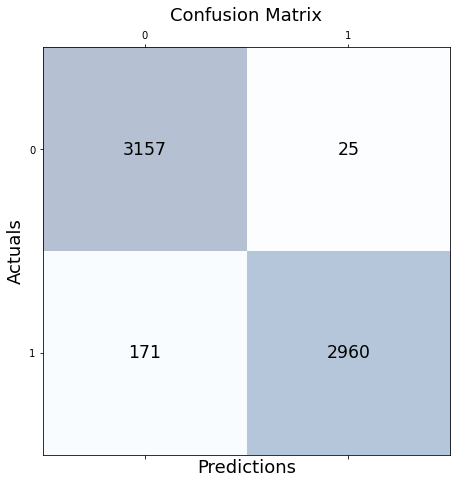

Epoch 1/10
198/198 [==============================] - 121s 613ms/step - loss: 0.0663 - accuracy: 0.9674 - f1_m: 0.9664 - precision_m: 0.9951 - recall_m: 0.9397 - val_loss: 0.0429 - val_accuracy: 0.9718 - val_f1_m: 0.9732 - val_precision_m: 0.9982 - val_recall_m: 0.9549
Epoch 2/10
198/198 [==============================] - 119s 603ms/step - loss: 0.0583 - accuracy: 0.9680 - f1_m: 0.9668 - precision_m: 0.9960 - recall_m: 0.9397 - val_loss: 0.0505 - val_accuracy: 0.9712 - val_f1_m: 0.9727 - val_precision_m: 0.9994 - val_recall_m: 0.9529
Epoch 3/10
198/198 [==============================] - 122s 616ms/step - loss: 0.0555 - accuracy: 0.9682 - f1_m: 0.9670 - precision_m: 0.9964 - recall_m: 0.9398 - val_loss: 0.0510 - val_accuracy: 0.9718 - val_f1_m: 0.9731 - val_precision_m: 0.9962 - val_recall_m: 0.9564
Epoch 4/10
198/198 [==============================] - 122s 614ms/step - loss: 0.0537 - accuracy: 0.9684 - f1_m: 0.9674 - precision_m: 0.9967 - recall_m: 0.9403 - val_loss: 0.0586 - val_accur

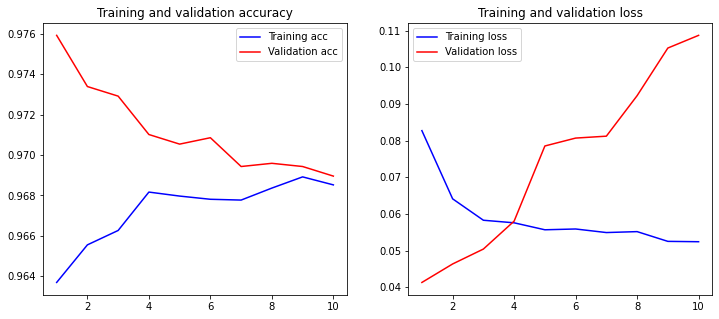

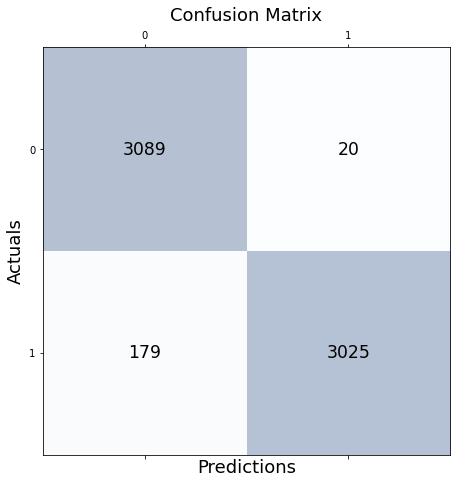

Average training accuracy is: 0.9716071128845215
Average training precision is: 0.9385001420974731
Average training recall is: 0.9095014810562134
Average training f1score is: 0.9187028646469116
Average testing accuracy is: 0.892835259437561
Average testing precision is: 0.8924801468849182
Average testing recall is: 0.8748397350311279
Average testing f1score is: 0.8723232507705688
it takes 6424.6615 seconds


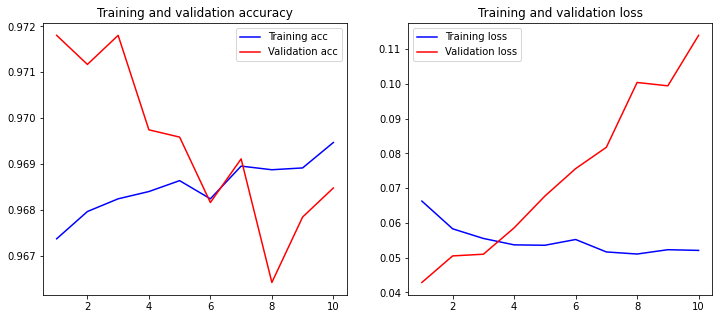

In [ ]:
embedding_dim = 300
vocab_size=len(word_index)+1
dr="drive/MyDrive/FinalCode/FinalTrained/AmhW2V/sg"

fn="AmW2vec300.bin"
embedding_index=AmEmbeddingIndexMain(dr,fn)
embmtrx=prepareEmbMatrixFinal(embedding_index,word_index,embedding_dim)
mpng='drive/MyDrive/FinalCode/FinalModel/AHSW2V300SGBDS12GZ.png'
model= create_model1(vocab_size, maxlen,embedding_dim,embmtrx,mpng)
x=data
y=labels
svmd='drive/MyDrive/FinalCode/FinalModel/AHSW2V300SGBDS12GZ.h5'
final_train_test(model,x,y,svmd,10,128)